<a href="https://colab.research.google.com/github/ImagingDataCommons/ai_medima_misc/blob/main/nnunet/notebooks/scientific_data_paper_usage_notes_nsclc_radiomics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From Andrey: 
- For the usage notes/notebook, I think we should have something that just uses the dataset, not creates it. 
- So it would download the files, - done
- install the packages needed to read/convert those files, - done
- demonstrate how to extract values and make summary plots, 
- show how information in the files can be used to further subset the data, 
- show how to do visualization of segmentations and images based on landmark annotations. 
We can use Vamsi as an external user to test that notebook(s).

-- 

This notebook provides instructions on how to create, interpret and visualize the data associated with the Scientific Data Paper [insert]. 

Before beginning, please set up a project using these instructions [insert]. 

We demonstrate how to: 
- Convert the DICOM Segmentation objects using multiple packages 
- Analyze the DICOM Structured Reports that hold the 3D shape radiomics features
- Analyze the DICOM Structured Reports that hold the body part landmarks and regions 

-- 

To do: 
- make the install packages/parameterization/environment setup easier!! 
- include instructions/link to creating a project 


Deepa Krishnaswamy
Brigham and Women's Hospital 
Dec 2022 

Meeting 3-6-23
- git issue highdicom converting to nii, need orientation 
- For the landmarks -- go from landmark to list of series that have the landmark
- For the regions -- go from region to list of series that have the region 
- Maybe split notebook later 
- Use pydicom_seg as well 
- For viz use Dennis' method as well as ITK widgets 
- Also provide examples of reading the SRs! 

# Parameterization

In [1]:
project_name = 'idc-external-018'

# Authorize 
from google.colab import auth
auth.authenticate_user()

# Install packages 

In [2]:
!pip install pyradiomics

!pip install pyplastimatch

!pip uninstall highdicom
!git clone https://github.com/herrmannlab/highdicom.git
#!cd highdicom && python setup.py install
!cd highdicom && pip install .

!pip install pydicom
!pip install pydicom-seg

!pip install --upgrade --pre -q "itk==5.3.0"
!pip install 'itkwidgets>=1.0a23'
!pip install imjoy-elfinder


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 KB 43.3 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.0.1-cp39-cp39-linux_x86_64.whl size=185767 sha256=0070c223a9c06cb19a7e5fc2d3d2391e503a70bd14e55c5bfe898e17672767b6
  Stored in directory: /root/.cache/pip/wheels/62/0f/06/e8bdcc276fc814981e11a2fc4da7ad0da0a7e68a60fe90e747
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=b4e6cdca8a05d1965b4163361313f244c7e98724e43ab6ff72966d61b91dc7b0
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc8

In [3]:
!gcloud config set project $project_name

Updated property [core/project].


In [4]:
import os 
import sys 
import time 
import json 
import subprocess 
import glob
import shutil  

import numpy as np 
import matplotlib.pyplot as plt 
import nibabel as nib 
import SimpleITK as sitk
import pandas as pd 
import seaborn as sb 
import db_dtypes

from google.cloud import bigquery
from google.cloud import storage

import pydicom
import pydicom_seg
from collections import OrderedDict

import itk 
from itkwidgets import view
from scipy import ndimage

import seaborn as sns



Let's install and import the packages needed to create Structured Reports (SR). -- I will simplify this later!

In [101]:
# Packages for the structured report 

import highdicom

from pathlib import Path

import highdicom as hd

from pydicom.uid import generate_uid
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

from highdicom.sr.content import (
    FindingSite,
    ImageRegion,
    ImageRegion3D,
    SourceImageForRegion,
    SourceImageForMeasurement,
    SourceImageForMeasurementGroup
)
from highdicom.sr.enum import GraphicTypeValues3D
from highdicom.sr.enum import GraphicTypeValues
from highdicom.sr.sop import Comprehensive3DSR, ComprehensiveSR
from highdicom.sr.templates import (
    DeviceObserverIdentifyingAttributes,
    Measurement,
    MeasurementProperties,
    MeasurementReport,
    MeasurementsAndQualitativeEvaluations,
    ObservationContext,
    ObserverContext,
    PersonObserverIdentifyingAttributes,
    PlanarROIMeasurementsAndQualitativeEvaluations,
    RelationshipTypeValues,
    TrackingIdentifier,
    QualitativeEvaluation,
    ImageLibrary,
    ImageLibraryEntryDescriptors,
    ValueTypeValues # I added 
)
from highdicom.sr.value_types import (
    CodedConcept,
    CodeContentItem,
)

import logging
logger = logging.getLogger("highdicom.sr.sop")
logger.setLevel(logging.INFO)


We will next install and import a number of packages needed for organizing and converting DICOM files:

1.    `dicomsort`, a package for sorting DICOM files into a directory tree using specific DICOM fields. 
2.   `plastimatch`, a package used to convert RTSTRUCT DICOM files to nrrd. 
3.   `dcmqi`, a package which converts SEG DICOM files to nrrd.
4.  `dcm2niix`, a package for converting DICOM files to nii 


In [6]:
# %%capture
start_time=time.time()

# FIXME: see if we can convert this to a package as well
# dicomsort 
if os.path.isdir('/content/src/dicomsort'):
  try:
    shutil.rmtree('/content/src/dicomsort')
  except OSError as err:
    print("Error: %s : %s" % ("dicomsort", err.strerror)) 
# !git clone https://github.com/pieper/dicomsort.git 
!git clone https://github.com/pieper/dicomsort.git src/dicomsort

# plastimatch and pyplastimatch
# FIXME: already installed in one of the first cells (also takes care of some
# of the other dependencies, e.g., SITK) 
!sudo apt install plastimatch 
import pyplastimatch as pypla

# FIXME: see if we can convert this to a package as well
# dcmqi 
!wget https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz
!tar zxvf dcmqi-1.2.5-linux.tar.gz
!cp dcmqi-1.2.5-linux/bin/* /usr/local/bin/

# dcm2niix 
# !sudo apt-get install dcm2niix 
# !curl -fLO https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
# !unzip "/content/dcm2niix_lnx.zip"
!wget https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
!unzip dcm2niix_lnx.zip
!cp /content/dcm2niix /usr/local/bin 

end_time = time.time()
print ('time to install: ' + str(end_time-start_time))

Cloning into 'src/dicomsort'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 169 (delta 23), reused 34 (delta 17), pack-reused 126
Receiving objects: 100% (169/169), 87.85 KiB | 3.99 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libdcmtk14 libdlib-data libdlib19 libfftw3-single3 libinsighttoolkit4.13
  libminc2-5.2.0 libnifti2
Suggested packages:
  libfftw3-bin libfftw3-dev
The following NEW packages will be installed:
  libdcmtk14 libdlib-data libdlib19 libfftw3-single3 libinsighttoolkit4.13
  libminc2-5.2.0 libnifti2 plastimatch
0 upgraded, 8 newly installed, 0 to remove and 22 not upgraded.
Need to get 80.1 MB of archives.
After this operation, 169 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu

# nnU-Net prediction analysis

## Download

### Download DICOM Segmentation objects 

Get the gcs url to download the SEG files 

In [9]:
client = bigquery.Client(project=project_name)
# table_id = ".".join(['idc-dev-etl', 'idc_v13_pub', 'dicom_all']) # later will change to use idc_current. 
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    PatientID, 
    StudyInstanceUID,
    SeriesInstanceUID, 
    SOPInstanceUID, 
    SeriesDescription,
    gcs_url
  FROM 
    {table_id}
  WHERE
    Modality = "SEG" AND 
    collection_id = "nsclc_radiomics"
  ORDER BY 
    PatientID, 
    StudyInstanceUID, 
    SeriesInstanceUID;
"""

job_config = bigquery.QueryJobConfig()
seg_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


Choose single patient and download the files 

In [10]:
PatientID = sorted(list(set(seg_df['PatientID'].values)))[1] 
print(PatientID)

LUNG1-002


In [11]:
seg_df_patient = seg_df[seg_df['PatientID']==PatientID] 
seg_df_patient

,PatientID,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,SeriesDescription,gcs_url
4,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.2.276.0.7230010.3.1.3.2323910823.11504.15972...,1.2.276.0.7230010.3.1.4.2323910823.11504.15972...,Segmentation,gs://idc-open-cr/eff917af-8a2a-42fe-9e12-22bce...
5,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.2.276.0.7230010.3.1.3.481034752.112041.16656...,1.2.276.0.7230010.3.1.4.481034752.112041.16656...,3d_lowres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/99ce9653-4f74-4954-aa...
6,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.2.276.0.7230010.3.1.3.481034752.398262.16657...,1.2.276.0.7230010.3.1.4.481034752.398262.16657...,2d-tta_nnU-Net_Segmentation,gs://public-datasets-idc/e4bc75aa-cfca-4b6f-9e...
7,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.2.276.0.7230010.3.1.3.481034752.68078.166429...,1.2.276.0.7230010.3.1.4.481034752.68078.166429...,3d_fullres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/a8adc5d1-d4af-4653-96...


Download the SEG files 

In [12]:
# Download all the DICOM Segmentation files 

# Create the text file to hold gsc_url 
gcsurl_temp = seg_df_patient["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
seg_directory = "/content/seg"
if not os.path.isdir(seg_directory):
  os.mkdir(seg_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $seg_directory

Copying gs://idc-open-cr/eff917af-8a2a-42fe-9e12-22bceaac5da9.dcm...
Copying gs://public-datasets-idc/99ce9653-4f74-4954-aa00-e94470abeee7.dcm...
Copying gs://public-datasets-idc/a8adc5d1-d4af-4653-966a-f0132333fd7e.dcm...
Copying gs://public-datasets-idc/e4bc75aa-cfca-4b6f-9ee9-e98d47b212d5.dcm...
| [4/4 files][ 41.8 MiB/ 41.8 MiB] 100% Done                                    
Operation completed over 4 objects/41.8 MiB.                                     


Use dicomsort to sort the DICOM files 

In [13]:
# Sort files 
seg_directory_sorted = "/content/seg_sorted"
if not os.path.join(seg_directory_sorted):
  os.mkdir(seg_directory_sorted)

!python src/dicomsort/dicomsort.py -u $seg_directory $seg_directory_sorted/%PatientID/%Modality/%SeriesDescription.dcm



100% 4/4 [00:01<00:00,  3.87it/s]
Files sorted


In [14]:
input_dicom_files = sorted(os.listdir(os.path.join(seg_directory_sorted,PatientID,"SEG")))
input_dicom = os.path.join(seg_directory_sorted,PatientID,"SEG",input_dicom_files[0])

### Download the associated CT files 

In [15]:
# Get the referenced seriesInstanceUID from the input_dicom 

dcm = pydicom.dcmread(input_dicom)
# series_id = dcm['0020', '000e'].value # later figure out what field to use. 
# series_id = dcm['0008', '1115']['0020', '000e'].value
series_id = dcm['0008', '1115'][0]['SeriesInstanceUID'].value # # later figure out what field to use. 


In [16]:
client = bigquery.Client(project=project_name)
  
query_view = f"""
  SELECT 
    SeriesInstanceUID,
    SOPInstanceUID, 
    gcs_url 
  FROM
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SeriesInstanceUID = @series_id;
  """

start_time = time.time()
job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                       ])
result = client.query(query_view, job_config=job_config) 
series_df = result.to_dataframe(create_bqstorage_client=True)
end_time = time.time()
print ('elapsed time: ' + str(end_time-start_time)) 

elapsed time: 2.5664162635803223


In [17]:
# Download the gcs_urls 

# Create the text file to hold gsc_url 
gs_file_path = "gcs_paths.txt"
series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# Download the series 
download_path = "/content/raw"
if not os.path.isdir(download_path):
  os.mkdir(download_path)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $download_path

Copying gs://idc-open-cr/8d11ef77-909c-4de3-b550-cb3bd7f00d8a.dcm...
Copying gs://idc-open-cr/b670ab0d-71a0-4a30-af78-c0676666d81d.dcm...
Copying gs://idc-open-cr/07610515-ec98-4852-bdd8-0dd5a91f5478.dcm...
Copying gs://idc-open-cr/93361b61-85b9-4fc0-b015-d02245f2459c.dcm...
Copying gs://idc-open-cr/52ea13a8-f89b-4da0-8435-0293d117069a.dcm...
Copying gs://idc-open-cr/b85dc3e1-8c86-473d-a62d-0bb0f4b10a89.dcm...
Copying gs://idc-open-cr/ebed7073-8a61-46f8-adf0-929a39e1e8b8.dcm...
Copying gs://idc-open-cr/eafbfe99-84f0-44e5-a31d-21856912dc4d.dcm...
Copying gs://idc-open-cr/66065989-9029-40c3-9f3f-66794ecaca3b.dcm...
Copying gs://idc-open-cr/5f1ab5c8-0c48-45bd-9166-90449e14616b.dcm...
Copying gs://idc-open-cr/eb161df8-b9f1-4b30-89f1-cfe557671c48.dcm...
Copying gs://idc-open-cr/805b08bb-1935-4007-94a7-9ac04b14993a.dcm...
Copying gs://idc-open-cr/8ddfd645-fa50-4843-bce7-a629988a0c38.dcm...
Copying gs://idc-open-cr/29946a45-da88-447c-9738-56c75a3824e1.dcm...
Copying gs://idc-open-cr/867e960a-

## Conversion of DICOM files

### Convert the raw CT files to nii 

In [18]:
# Convert to nifti 
ct_nifti_directory = "/content/ct_nii" 
if not os.path.isdir(ct_nifti_directory): 
  os.mkdir(ct_nifti_directory)

cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory, download_path)
print(cmd)
ret = os.system(cmd)
print(ret)

dcm2niix -z y -m y -o /content/ct_nii  /content/raw 
0


In [19]:
# Rename file 

nii_file_orig = [os.path.join(ct_nifti_directory,f) for f in os.listdir(ct_nifti_directory) if f.endswith('.nii.gz')][0] 
nii_file = "/content/ct.nii.gz"
os.rename(nii_file_orig, nii_file)


### Use dcmqi to convert the DICOM Segmentation object to a nifti file 

Insert text of the output of dcmqi. 

In [20]:
input_dicom_files = sorted(os.listdir(os.path.join(seg_directory_sorted,PatientID,"SEG")))
input_dicom = os.path.join(seg_directory_sorted,PatientID,"SEG",input_dicom_files[0])

In [21]:
output_directory_seg_converted_dcmqi = "/content/seg_converted_dcmqi"
if not os.path.isdir(output_directory_seg_converted_dcmqi):
  os.mkdir(output_directory_seg_converted_dcmqi)

print(input_dicom)
print(output_directory_seg_converted_dcmqi)

# !segimage2itkimage --outputType "nrrd" --outputDirectory $output_directory_seg_converted_dcmqi --inputDICOM $input_dicom 
!segimage2itkimage --outputType "nii" --outputDirectory $output_directory_seg_converted_dcmqi --inputDICOM $input_dicom 


/content/seg_sorted/LUNG1-002/SEG/2d-tta_nnU-Net_Segmentation.dcm
/content/seg_converted_dcmqi
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
Row direction: 1 0 0
Col direction: 0 -1 0
Z direction: 0 0 -1
Total frames: 205
Total frames with unique IPP: 85
Total overlapping frames: 77
Origin: [-250.112, 249.135, 154.6]


Resample the segmentation back to the original size

In [22]:
nii_file

'/content/ct.nii.gz'

In [23]:
# Resample each file 

seg_files = [os.path.join(output_directory_seg_converted_dcmqi,f) for f in os.listdir(output_directory_seg_converted_dcmqi) if f.endswith('.nii.gz')] 
num_seg_files = len(seg_files)
print('num_seg_files: ' + str(num_seg_files))

output_directory_seg_converted_dcmqi_resampled = "/content/seg_converted_dcmqi_resampled"
if not os.path.isdir(output_directory_seg_converted_dcmqi_resampled):
  os.mkdir(output_directory_seg_converted_dcmqi_resampled)

for n in range(0,num_seg_files):
  fixed_image = nii_file
  input_image = os.path.join(output_directory_seg_converted_dcmqi, str(n+1) + ".nii.gz")
  output_image = os.path.join(output_directory_seg_converted_dcmqi_resampled, str(n+1) + ".nii.gz")
  !plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn

num_seg_files: 4
Trying to write image to /content/seg_converted_dcmqi_resampled/1.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/2.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/3.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/4.nii.gz


In [24]:
# Combine the files into a single label file 

seg_files = sorted([os.path.join(output_directory_seg_converted_dcmqi_resampled,f) for f in os.listdir(output_directory_seg_converted_dcmqi_resampled) if f.endswith('.nii.gz')]) 
                                                                                                
for n in range(0,num_seg_files): 
  if n==0:
    nii = nib.load(seg_files[n])
    volume = nii.get_fdata() 
  else: 
    nii_segment = nib.load(seg_files[n])
    volume_segment = nii_segment.get_fdata() 
    volume[volume_segment>0] = n+1
    
print(np.unique(volume))

volume_nii = nib.Nifti1Image(volume, None, nii.header)
nib.save(volume_nii, '/content/segmentation_dcmqi_resampled.nii.gz')


[0. 1. 2. 3. 4.]


### Use pydicom_seg to convert the DICOM Segmentation object to a nifti file

In [25]:
!pip install pydicom-seg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import pydicom
import pydicom_seg
import SimpleITK as sitk

output_directory_seg_converted_pydicom = "/content/seg_converted_pydicom"
if not os.path.isdir(output_directory_seg_converted_pydicom):
  os.mkdir(output_directory_seg_converted_pydicom)

dcm = pydicom.dcmread(input_dicom)

reader = pydicom_seg.SegmentReader()
result = reader.read(dcm)

for segment_number in result.available_segments:
    image_data = result.segment_data(segment_number)  # directly available
    image = result.segment_image(segment_number)  # lazy construction
    print(image.GetSize())
    # sitk.WriteImage(image, f'/content/pydicom_seg/segmentation-{segment_number}.nii.gz', True) 
    sitk.WriteImage(image, f'/content/seg_converted_pydicom/{segment_number}.nii.gz', True) # resample back to CT in next step 


(512, 512, 85)
(512, 512, 85)
(512, 512, 85)
(512, 512, 85)


In [27]:
# Resample each file 

seg_files = [os.path.join(output_directory_seg_converted_pydicom,f) for f in os.listdir(output_directory_seg_converted_pydicom) if f.endswith('.nii.gz')] 
num_seg_files = len(seg_files)
print('num_seg_files: ' + str(num_seg_files))

output_directory_seg_converted_pydicom_resampled = "/content/seg_converted_pydicom_seg_resampled"
if not os.path.isdir(output_directory_seg_converted_pydicom_resampled):
  os.mkdir(output_directory_seg_converted_pydicom_resampled)

for n in range(0,num_seg_files):
  fixed_image = nii_file
  input_image = os.path.join(output_directory_seg_converted_pydicom, str(n+1) + ".nii.gz")
  output_image = os.path.join(output_directory_seg_converted_pydicom_resampled, str(n+1) + ".nii.gz")
  !plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn



num_seg_files: 4
Trying to write image to /content/seg_converted_pydicom_seg_resampled/1.nii.gz
Trying to write image to /content/seg_converted_pydicom_seg_resampled/2.nii.gz
Trying to write image to /content/seg_converted_pydicom_seg_resampled/3.nii.gz
Trying to write image to /content/seg_converted_pydicom_seg_resampled/4.nii.gz


In [28]:
# Combine the files into a single label file 

seg_files = sorted([os.path.join(output_directory_seg_converted_pydicom_resampled,f) for f in os.listdir(output_directory_seg_converted_pydicom_resampled) if f.endswith('.nii.gz')]) 
                                                                                                
for n in range(0,num_seg_files): 
  if n==0:
    nii = nib.load(seg_files[n])
    volume = nii.get_fdata() 
  else: 
    nii_segment = nib.load(seg_files[n])
    volume_segment = nii_segment.get_fdata() 
    volume[volume_segment>0] = n+1
print(np.unique(volume))

volume_nii = nib.Nifti1Image(volume, None, nii.header)
nib.save(volume_nii, '/content/segmentation_pydicom_resampled.nii.gz')

[0. 1. 2. 3. 4.]


###  Use highdicom + code from dcmqi to convert the DICOM Segmentation object to a nifti file 

Using seg = hd.seg.segread and seg.get_pixels_by_source_instance, we can get the segmentation labels as a numpy array. Unfortunately, we are not returned information about the orientation and therefore do not have a way of mapping this back to the same space as the CT. 

Therefore, we get the position and orientation information ourselves and reconstruct a 3D volume. As reference we use https://github.com/QIICR/dcmqi/blob/master/libsrc/ImageSEGConverter.cpp#L483

In [29]:
# Use highdicom to read the DICOM Segmentation file 
seg = hd.seg.segread(input_dicom) 

# Extract orientation information we need for reconstruction
Rows = np.int32(seg.Rows)
Columns = np.int32(seg.Columns)
ImageOrientationPatient = np.float32(seg.SharedFunctionalGroupsSequence[0].PlaneOrientationSequence[0].ImageOrientationPatient)
ImageOrientationPatient_x = ImageOrientationPatient[0:3]
ImageOrientationPatient_y = ImageOrientationPatient[3:6]
SliceThickness = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SliceThickness)
SpacingBetweenSlices = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SpacingBetweenSlices)
PixelSpacing_x = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[0])
PixelSpacing_y = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[1])

# calculate cross product (sliceDirection) using ImageOrientationPatient
orientation_x = ImageOrientationPatient[0:3] / np.linalg.norm(ImageOrientationPatient[0:3])
orientation_y = ImageOrientationPatient[3:5] / np.linalg.norm(ImageOrientationPatient[4:6])
sliceDirection = np.cross(orientation_x, orientation_y)

print('Rows: ' + str(Rows))
print('Columns: ' + str(Columns))
print('ImageOrientationPatient: ' + str(ImageOrientationPatient))
print('sliceDirection: ' + str(sliceDirection))
print('SliceThickness: ' + str(SliceThickness))
print('SpacingBetweenSlices: ' + str(SpacingBetweenSlices)) 
print('PixelSpacing_x: ' + str(PixelSpacing_x)) 
print('PixelSpacing_y: ' + str(PixelSpacing_y))

Rows: 512
Columns: 512
ImageOrientationPatient: [ 1.  0.  0.  0. -1.  0.]
sliceDirection: [ 0.  0. -1.]
SliceThickness: 3.0
SpacingBetweenSlices: 3.0
PixelSpacing_x: 0.977
PixelSpacing_y: 0.977


In [30]:
# ------------------ # 
# Using the PerFrameFunctionalGroupsSequence, we extract the segment_number (in our case we have 4 segments), 
# and the associated ImagePositionPatient for each of the slices 

# This is the total number of per frame functional groups 
num_seg_slices = len(seg.PerFrameFunctionalGroupsSequence)
print('num_seg_slices: ' + str(num_seg_slices))

segment_number = [] # keeps track of which segment 
segment_ImagePositionPatient = [] 
for n in range(0,num_seg_slices):
  segment_number.append(np.int32(seg.PerFrameFunctionalGroupsSequence[n].SegmentIdentificationSequence[0].ReferencedSegmentNumber))
  segment_ImagePositionPatient.append(np.float32(np.asarray(seg.PerFrameFunctionalGroupsSequence[n].PlanePositionSequence[0].ImagePositionPatient)))
segment_number = np.asarray(segment_number)
segment_ImagePositionPatient = np.stack(segment_ImagePositionPatient, axis=0)

# Create a dict to store the number of unique segments, and the number of frames for each  
number_of_segments, segment_number_of_frames = np.unique(segment_number, return_counts=True)
segment_number_dict = dict(zip(number_of_segments, segment_number_of_frames))
print('segment_number_dict: ' + str(segment_number_dict))

# ------------------ # 
# We then need to compute the volume Extent, by getting the number of unique ImagePositionPatient values 

unique_ImagePositionPatient = np.unique(segment_ImagePositionPatient, axis=0)
num_slices = len(unique_ImagePositionPatient)
print('num_slices: ' + str(num_slices)) 

# ------------------- # 
# We need to calculate the image origin which will be used for stacking the 
# slices for each of the segments in the right order 

# Find which x,y,z index we should use for ImagePositionPatient 
max_ind = np.argmax(np.abs(sliceDirection))
print('max_ind: ' + str(max_ind))

# Find which one has the minimum value in the max_ind position 
origin_ind = np.argmin(unique_ImagePositionPatient[:,max_ind])
print('origin_ind: ' + str(origin_ind))

# ImageOrigin = np.min(unique_ImagePositionPatient[origin_ind,:])
ImageOrigin = unique_ImagePositionPatient[origin_ind,:]
print('ImageOrigin: ' + str(ImageOrigin))

origin_ind_max = np.argmax(unique_ImagePositionPatient[:,max_ind])
print('origin_ind_max: ' + str(origin_ind_max))
ImageOrigin_max = unique_ImagePositionPatient[origin_ind_max,:]
print('ImageOrigin_max: ' + str(ImageOrigin_max))

num_seg_slices: 205
segment_number_dict: {1: 77, 2: 26, 3: 39, 4: 63}
num_slices: 85
max_ind: 2
origin_ind: 0
ImageOrigin: [-250.112     249.13501   -97.399994]
origin_ind_max: 84
ImageOrigin_max: [-250.112    249.13501  154.6    ]


In [31]:
# This function is to map the ImagePositionPatient to an axial slice index value 

def map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind):

  dist = ImageOrigin - imagepositionpatient 
  # slice_index = np.int32(np.round(dist[max_ind] / SpacingBetweenSlices) )
  slice_index = np.int32(np.around(dist[max_ind] / SpacingBetweenSlices) ) - 1 

  return slice_index 

In [32]:
# --------------------------# 
# Now we form the volume

# We get the pixel_array from seg - this concatenates all labels in the x axis 
pixel_array = seg.pixel_array 
print('pixel_array: ' + str(pixel_array.shape))

# We want to form a single volume for all labels 
volume = np.zeros((Rows, Columns, num_slices)) 
print('volume: ' + str(volume.shape))

# This is an index to make sure it is the same as the x value for pixel_array 
matching_rows_sum = 0 

# For each axial slice, and for each segment present in that slice, we add 
# the appropriate labels 
for n in range(0,num_slices):

  # Get a unique IPP 
  imagepositionpatient = unique_ImagePositionPatient[n,:]

  # Find the matching rows indices in segment_ImagePositionPatient 
  # The length of this is equal to the number of segments that are present in the same slice 
  matching_rows = np.int32(np.where((segment_ImagePositionPatient == imagepositionpatient).all(axis=1))[0])

  # Get the corresonding segment numbers 
  matching_segment_numbers = segment_number[matching_rows]

  # Get the axial slice index for this unique IPP 
  # slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin, max_ind)
  slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind)
  
  # Use this index to make sure it is the same as the x value for pixel_array 
  matching_rows_sum += len(matching_segment_numbers)

  # For each segment present in the slice, add the appropriate slice from the pixel_array 
  for m in range(0,len(matching_segment_numbers)): 
    slice_keep = pixel_array[matching_rows[m],:,:]
    # volume[:,:,slice_num,m] = slice_keep * matching_segment_numbers[m] # 1,2,3,4 
    volume[:,:,slice_num] = volume[:,:,slice_num] + (slice_keep * matching_segment_numbers[m])

# Print some error checking 
print('Number of axial slices: ' + str(len(unique_ImagePositionPatient))) # Should be equal to the number of slices in our final volume 
print('Segment numbers: ' + str(np.unique(volume))) # Should be the segment numbers 
print('matching_rows_sum: ' + str(matching_rows_sum)) # Should be equal to the x axis of pixel_array

pixel_array: (205, 512, 512)
volume: (512, 512, 85)
Number of axial slices: 85
Segment numbers: [0. 1. 2. 3. 4.]
matching_rows_sum: 205


ITK image instead of nifti 
check ImageOrigin 



In [33]:
# --------------- # 
# Now that we have the volume, and the associated orientation information, we can form a nifti file 

# First set the appropriate srows 
srow_x = ImageOrientationPatient_x * PixelSpacing_x 
srow_y = ImageOrientationPatient_y * PixelSpacing_y 
srow_z = sliceDirection * SpacingBetweenSlices 
print(srow_x)
print(srow_y)
print(srow_z)

# Create the proper header for the nifti file 
volume = volume.astype(np.uint8)
print(type(volume))
print(volume.dtype)
nii = nib.Nifti1Image(volume, np.eye(4))
header = nii.header 
header['pixdim'] = [1, PixelSpacing_x, PixelSpacing_y, SpacingBetweenSlices, 1, 1, 1, 1,]   

# This works but why?? Have to multiple origin by sliceDirection or something?? 
header['srow_y'] = [ srow_x[0], srow_x[1], srow_x[2], -ImageOrigin_max[1] ]
header['srow_x'] = [ srow_y[0], srow_y[1], srow_y[2], -ImageOrigin_max[0] ]
header['srow_z'] = [ srow_z[0], srow_z[1], srow_z[2], ImageOrigin_max[2] ]

print(header)

output_directory_seg_converted_highdicom = '/content/seg_converted_highdicom'
if not os.path.isdir(output_directory_seg_converted_highdicom): 
  os.mkdir(output_directory_seg_converted_highdicom)

nii = nib.Nifti1Image(volume, None, header)
nib.save(nii, os.path.join(output_directory_seg_converted_highdicom, 'highdicom_volume.nii.gz'))


[0.977 0.    0.   ]
[ 0.    -0.977  0.   ]
[ 0.  0. -3.]
<class 'numpy.ndarray'>
uint8
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512  85   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.    0.977 0.977 3.    1.    1.    1.    1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x    

In [34]:
# ----------------- # 
# Now we can resample this nifti file back to the original CT space 

# Resample to the original CT 

output_directory_seg_converted_highdicom_resampled = "/content/seg_converted_highdicom_resampled" 
if not os.path.isdir(output_directory_seg_converted_highdicom_resampled): 
  os.mkdir(output_directory_seg_converted_highdicom_resampled)

seg_file = os.path.join(output_directory_seg_converted_highdicom, 'highdicom_volume.nii.gz')
seg_file_resampled = os.path.join(output_directory_seg_converted_highdicom_resampled, 'highdicom_volume_resampled.nii.gz')

fixed_image = nii_file
input_image = seg_file
output_image = seg_file_resampled
!plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn

Trying to write image to /content/seg_converted_highdicom_resampled/highdicom_volume_resampled.nii.gz


In [35]:
shutil.copy(seg_file_resampled, "/content/segmentation_highdicom_resampled.nii.gz")


'/content/segmentation_highdicom_resampled.nii.gz'

### OLD - DELETE later. Use highdicom + code from dcmqi to convert the DICOM Segmentation objects to a nifti file 

We should not have to pass in the source_sops from the CT files in order to recreate the segmentations. Instead, read the segmentations using the highdicom code, and then manually recreate the 3D numpy array with the proper spacing etc ourselves only by using data from the DICOM SEG file. 

Notes: 
https://github.com/QIICR/dcmqi/blob/master/libsrc/ImageSEGConverter.cpp#L483 

In [27]:
seg = hd.seg.segread(input_dicom) 
source_uids = seg.get_source_image_uids() 
source_sops = [uids[2] for uids in source_uids]

pix = seg.get_pixels_by_source_instance(
          source_sops, 
          ignore_spatial_locations=True,
          # segment_numbers=[1,2,3,4], 
          assert_missing_frames_are_empty=True,
          combine_segments=True
)

print (pix.shape) # (85, 512, 512), original CT is (111, 512, 512)

(85, 512, 512)


In [38]:
import numpy as np 

Rows = np.int32(seg.Rows)
Columns = np.int32(seg.Columns)
ImageOrientationPatient = np.float32(seg.SharedFunctionalGroupsSequence[0].PlaneOrientationSequence[0].ImageOrientationPatient)
ImageOrientationPatient_x = ImageOrientationPatient[0:3]
ImageOrientationPatient_y = ImageOrientationPatient[3:6]
SliceThickness = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SliceThickness)
SpacingBetweenSlices = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SpacingBetweenSlices)
PixelSpacing_x = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[0])
PixelSpacing_y = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[1])

# calculate cross product (sliceDirection) using ImageOrientationPatient
orientation_x = ImageOrientationPatient[0:3] / np.linalg.norm(ImageOrientationPatient[0:3])
orientation_y = ImageOrientationPatient[3:5] / np.linalg.norm(ImageOrientationPatient[4:6])
sliceDirection = np.cross(orientation_x, orientation_y)

print('Rows: ' + str(Rows))
print('Columns: ' + str(Columns))
print('ImageOrientationPatient: ' + str(ImageOrientationPatient))
print ('sliceDirection: ' + str(sliceDirection))
print('SliceThickness: ' + str(SliceThickness))
print('SpacingBetweenSlices: ' + str(SpacingBetweenSlices)) 
print('PixelSpacing_x: ' + str(PixelSpacing_x)) 
print('PixelSpacing_y: ' + str(PixelSpacing_y))


Rows: 512
Columns: 512
ImageOrientationPatient: [ 1.  0.  0.  0. -1.  0.]
sliceDirection: [ 0.  0. -1.]
SliceThickness: 3.0
SpacingBetweenSlices: 3.0
PixelSpacing_x: 0.977
PixelSpacing_y: 0.977


In [39]:
# This is the total number of per frame functional groups 
num_seg_slices = len(seg.PerFrameFunctionalGroupsSequence)
print('num_seg_slices: ' + str(num_seg_slices))
segment_number = [] # keeps track of which segment 
segment_ImagePositionPatient = [] 
for n in range(0,num_seg_slices):
  segment_number.append(np.int32(seg.PerFrameFunctionalGroupsSequence[n].SegmentIdentificationSequence[0].ReferencedSegmentNumber))
  segment_ImagePositionPatient.append(np.float32(np.asarray(seg.PerFrameFunctionalGroupsSequence[n].PlanePositionSequence[0].ImagePositionPatient)))
segment_ImagePositionPatient = np.stack(segment_ImagePositionPatient, axis=0)
# print(segment_number) 
# print(segment_ImagePositionPatient)

segment_number = np.asarray(segment_number)


num_seg_slices: 205


In [40]:
# This is the number of unique segments, and the number of frames for each  
number_of_segments, segment_number_of_frames = np.unique(segment_number, return_counts=True)
print('number_of_segments: ' + str(number_of_segments)) 
print('segment_number_of_frames: ' + str(segment_number_of_frames))
segment_number_dict = dict(zip(number_of_segments, segment_number_of_frames))
print('segment_number_dict: ' + str(segment_number_dict))
segment_number_dict.keys()
segment_number_dict[1]

# print(len(seg.PerFrameFunctionalGroupsSequence))

## Compute the volumeExtent -- number of unique ImagePositionPatient? 

unique_ImagePositionPatient = np.unique(segment_ImagePositionPatient, axis=0)
print('unique_ImagePositionPatient: ' + str(len(unique_ImagePositionPatient)))
num_slices = len(unique_ImagePositionPatient)
print('num_slices: ' + str(num_slices)) 

# Find which x,y,z index we should use for ImagePositionPatient 
max_ind = np.argmax(np.abs(sliceDirection))
print('max_ind: ' + str(max_ind))

# Find which one has the minimum value in the max_ind position 
origin_ind = np.argmin(unique_ImagePositionPatient[:,max_ind])
print('origin_ind: ' + str(origin_ind))

# ImageOrigin = np.min(unique_ImagePositionPatient[origin_ind,:])
ImageOrigin = unique_ImagePositionPatient[origin_ind,:]
print('ImageOrigin: ' + str(ImageOrigin))

origin_ind_max = np.argmax(unique_ImagePositionPatient[:,max_ind])
print('origin_ind_max: ' + str(origin_ind_max))
ImageOrigin_max = unique_ImagePositionPatient[origin_ind_max,:]
print('ImageOrigin_max: ' + str(ImageOrigin_max))

number_of_segments: [1 2 3 4]
segment_number_of_frames: [77 26 39 63]
segment_number_dict: {1: 77, 2: 26, 3: 39, 4: 63}
unique_ImagePositionPatient: 85
num_slices: 85
max_ind: 2
origin_ind: 0
ImageOrigin: [-250.112     249.13501   -97.399994]
origin_ind_max: 84
ImageOrigin_max: [-250.112    249.13501  154.6    ]


In [41]:
# def map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin, max_ind):

#   dist = imagepositionpatient - ImageOrigin 
#   slice_index = np.int32(np.round(dist[max_ind] / SpacingBetweenSlices) )

#   # print('imagepositionpatient: ' + str(imagepositionpatient))
#   # print('ImageOrigin: ' + str(ImageOrigin))
#   # print('dist: ' + str(dist))
#   # print('dist[max_ind]: ' + str(dist[max_ind]))
#   # print('SpacingBetweenSlices: ' + str(SpacingBetweenSlices))

#   return slice_index 

def map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind):

  dist = ImageOrigin - imagepositionpatient 
  # slice_index = np.int32(np.round(dist[max_ind] / SpacingBetweenSlices) )
  slice_index = np.int32(np.around(dist[max_ind] / SpacingBetweenSlices) ) - 1 


  # print('imagepositionpatient: ' + str(imagepositionpatient))
  # print('ImageOrigin: ' + str(ImageOrigin))
  # print('dist: ' + str(dist))
  # print('dist[max_ind]: ' + str(dist[max_ind]))
  # print('SpacingBetweenSlices: ' + str(SpacingBetweenSlices))

  return slice_index 

In [42]:
# Form the volume 

pixel_array = seg.pixel_array #(205,512,512) 

# volume = np.zeros((Rows, Columns, num_slices, len(number_of_segments)))
volume = np.zeros((Rows, Columns, num_slices))
print('volume: ' + str(volume.shape))

matching_rows_sum = 0 

for n in range(0,num_slices):
  imagepositionpatient = unique_ImagePositionPatient[n,:]
  # find the matching rows indices in segment_ImagePositionPatient 
  matching_rows = np.int32(np.where((segment_ImagePositionPatient == imagepositionpatient).all(axis=1))[0])
  # get the corresonding segment numbers 
  matching_segment_numbers = segment_number[matching_rows]
  # get the corresponding 2D array for each from seg.pixel_array 
  # slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin, max_ind)
  slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind)
  # print('slice_num: ' + str(slice_num))
  matching_rows_sum += len(matching_segment_numbers)
  for m in range(0,len(matching_segment_numbers)): 
    slice_keep = pixel_array[matching_rows[m],:,:]
    # volume[:,:,slice_num,m] = slice_keep * matching_segment_numbers[m] # 1,2,3,4 
    volume[:,:,slice_num] = volume[:,:,slice_num] + (slice_keep * matching_segment_numbers[m])

print(len(unique_ImagePositionPatient))
print(np.unique(volume))
print('matching_rows_sum: ' + str(matching_rows_sum)) # should be 205, it is. 

volume: (512, 512, 85)
85
[0. 1. 2. 3. 4.]
matching_rows_sum: 205


In [43]:
print(np.unique(pixel_array))
print(np.unique(pix))
print(np.unique(volume))

[0 1]
[0 1 2 3 4]
[0. 1. 2. 3. 4.]


In [44]:
print(ImageOrientationPatient_x)
print(ImageOrientationPatient_y)
print(sliceDirection)
print(SpacingBetweenSlices)

# srow_x = ImageOrientationPatient_x * PixelSpacing_x 
# srow_y = ImageOrientationPatient_y * PixelSpacing_y 
# srow_x = ImageOrientationPatient_y * PixelSpacing_y 
# srow_y = ImageOrientationPatient_x * PixelSpacing_x 
srow_x = ImageOrientationPatient_x * PixelSpacing_x 
srow_y = ImageOrientationPatient_y * PixelSpacing_y 
srow_z = sliceDirection * SpacingBetweenSlices 
print(srow_x)
print(srow_y)
print(srow_z)

print(ImageOrigin_max)

[1. 0. 0.]
[ 0. -1.  0.]
[ 0.  0. -1.]
3.0
[0.977 0.    0.   ]
[ 0.    -0.977  0.   ]
[ 0.  0. -3.]
[-250.112    249.13501  154.6    ]


In [45]:
# Create the proper header for the nifti file 
volume = volume.astype(np.uint8)
print(type(volume))
print(volume.dtype)
nii = nib.Nifti1Image(volume, np.eye(4))
header = nii.header 
header['pixdim'] = [1, PixelSpacing_x, PixelSpacing_y, SpacingBetweenSlices, 1, 1, 1, 1,]   

# header['srow_x'] = [  ImageOrientationPatient_x[0]*PixelSpacing_x,      0,      0,    ImageOrigin[0]]
# header['srow_y'] = [ 0,     ImageOrientationPatient_y[1]*PixelSpacing_y,  0, ImageOrigin[1]]
# header['srow_z'] = [ 0, 0, SpacingBetweenSlices, sliceDirection[2]*ImageOrigin[2]]

# header['srow_x'] = [ srow_x[0], srow_x[1], srow_x[2], ImageOrigin_max[0]]
# header['srow_y'] = [ srow_y[0], srow_y[1], srow_y[2], ImageOrigin_max[1]]
# header['srow_x'] = [ srow_x[0], srow_x[1], srow_x[2], ImageOrigin_max[1]]
# header['srow_y'] = [ srow_y[0], srow_y[1], srow_y[2], ImageOrigin_max[0]]

# header['srow_y'] = [ srow_x[0], srow_x[1], srow_x[2], ImageOrigin_max[0]]
# header['srow_x'] = [ srow_y[0], srow_y[1], srow_y[2], ImageOrigin_max[1]]

# This almost works, but off by 1 pixel in x and y direction
# header['srow_y'] = [ srow_x[0], srow_x[1], srow_x[2], ImageOrigin_max[0]]
# header['srow_x'] = [ srow_y[0], srow_y[1], srow_y[2], ImageOrigin_max[1]]
# header['srow_z'] = [ srow_z[0], srow_z[1], srow_z[2], ImageOrigin_max[2]]

# This works but why?? Have to multiple origin by sliceDirection or something?? 
header['srow_y'] = [ srow_x[0], srow_x[1], srow_x[2], -ImageOrigin_max[1]]
header['srow_x'] = [ srow_y[0], srow_y[1], srow_y[2], -ImageOrigin_max[0]]
header['srow_z'] = [ srow_z[0], srow_z[1], srow_z[2], ImageOrigin_max[2]]

# header['srow_y'] = [ srow_x[0], srow_x[1], srow_x[2], ImageOrigin_max[0]]
# header['srow_x'] = [ srow_y[0], srow_y[1], srow_y[2], ImageOrigin_max[1]]
# header['srow_z'] = [ srow_z[0], srow_z[1], srow_z[2], ImageOrigin_max[2]]

print(header)

output_directory_seg_converted_highdicom = '/content/seg_converted_highdicom'
if not os.path.isdir(output_directory_seg_converted_highdicom): 
  os.mkdir(output_directory_seg_converted_highdicom)

nii = nib.Nifti1Image(volume, None, header)
nib.save(nii, os.path.join(output_directory_seg_converted_highdicom, 'highdicom_volume.nii.gz'))

<class 'numpy.ndarray'>
uint8
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512  85   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.    0.977 0.977 3.    1.    1.    1.    1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow

In [46]:
# Resample to the original CT 

output_directory_seg_converted_highdicom_resampled = "/content/seg_converted_highdicom_resampled" 
if not os.path.isdir(output_directory_seg_converted_highdicom_resampled): 
  os.mkdir(output_directory_seg_converted_highdicom_resampled)

seg_file = os.path.join(output_directory_seg_converted_highdicom, 'highdicom_volume.nii.gz')
seg_file_resampled = os.path.join(output_directory_seg_converted_highdicom_resampled, 'highdicom_volume_resampled.nii.gz')

fixed_image = nii_file
input_image = seg_file
output_image = seg_file_resampled
!plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn


Trying to write image to /content/seg_converted_highdicom_resampled/highdicom_volume_resampled.nii.gz


In [47]:
# Copy so consistent, change later 

shutil.copy(seg_file_resampled, "/content/segmentation_highdicom_resampled.nii.gz")
 

'/content/segmentation_highdicom_resampled.nii.gz'

### DELETE later - Use highdicom to convert the DICOM Segmentation objects to a nifti file

In [48]:
input_dicom

'/content/seg_sorted/LUNG1-002/SEG/2d-tta_nnU-Net_Segmentation.dcm'

In [49]:
# From Steve 

seg = hd.seg.segread(input_dicom) 
source_uids = seg.get_source_image_uids() 
source_sops = [uids[2] for uids in source_uids]

pix = seg.get_pixels_by_source_instance(
          source_sops, 
          ignore_spatial_locations=True,
          segment_numbers=[1,2,3,4], 
          # assert_missing_frames_are_empty=True
)
print(pix.shape) # but original CT is (111, 512, 512, 4)

(85, 512, 512, 4)


In [50]:
# Get a sorted list of the CT DICOM files 

files = [os.path.join("/content/raw",f) for f in os.listdir("/content/raw")]
num_files = len(files)

pos_all = []  
sop_all = [] 

for n in range(0,num_files):

  # read dcm file 
  filename = files[n]
  ds = dcmread(filename)
  # print(ds)

  # get ImageOrientation (0020, 0037)
  # ImageOrientation = ds['0x0020','0x0037'].value
  ImageOrientation = ds.ImageOrientationPatient
  #ImageOrientation = ds.ImageOrientationPatient.value

  # get ImagePositionPatient (0020, 0032) 
  # ImagePositionPatient = ds['0x0020','0x0032'].value
  ImagePositionPatient = ds.ImagePositionPatient

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)

  # get the SOPInstanceUID 
  # sop = ds['0x0008', '0x0018'].value
  sop = ds.SOPInstanceUID
  sop_all.append(sop)


#----- order the SOPInstanceUID/files by z value ----# 

sorted_ind = np.argsort(pos_all)
pos_all_sorted = np.array(pos_all)[sorted_ind.astype(int)]
sop_all_sorted = np.array(sop_all)[sorted_ind.astype(int)]
files_sorted = np.array(files)[sorted_ind.astype(int)]

In [51]:
# Get list of sorted SOP instance UIDs from the original CT file 
# match up 
# Copy transformation information from the CT nifti file?? 

# source_sops_ct = series_df['SOPInstanceUID'].values 
source_sops_ct = sop_all_sorted 

seg = hd.seg.segread(input_dicom) 

pix = seg.get_pixels_by_source_instance(
          source_sops_ct, 
          ignore_spatial_locations=True,
          segment_numbers=[1,2,3,4], 
          assert_missing_frames_are_empty=True,
          combine_segments=True
)
print(pix.shape) # matches original CT is (111, 512, 512)

pix = np.moveaxis(pix, 0, -1)
pix = np.flip(pix, axis=1)
print(pix.shape)


(111, 512, 512)
(512, 512, 111)


In [52]:
# save as nifti file 
# copy header from CT? 

ct_nii = nib.load("/content/ct.nii.gz")
ct_header = ct_nii.header 

nii = nib.Nifti1Image(pix, None, header=ct_header)  
nib.save(nii, "/content/highdicom_segmentation.nii.gz")

In [53]:
# # Can I pass in all sops from original CT DICOM? 
# # If I order them correctly 

# seg = hd.seg.segread(input_dicom) 
# source_uids = seg.get_source_image_uids() 
# source_sops = [uids[2] for uids in source_uids]

# pix = seg.get_pixels_by_source_instance(
#           source_sops, 
#           ignore_spatial_locations=True,
#           segment_numbers=[1,2,3,4], 
#           # assert_missing_frames_are_empty=True
# )
# print(pix.shape) # but original CT is (111, 512, 512, 4)


In [54]:
# # From new highdicom documentation

# import numpy as np 

# # Read in the segmentation using highdicom
# seg = hd.seg.segread(input_dicom)

# # SOP Instance UID of the single multiframe image from which the
# # segmentation was derived
# _, _, source_sop_instance_uid = seg.get_source_image_uids()[0]

# # Get the segmentation array for a subset of these images:
# pixels = seg.get_pixels_by_source_frame(
#     source_sop_instance_uid=source_sop_instance_uid,
#     source_frame_numbers=range(1,112),
#     assert_missing_frames_are_empty=True,
#     segment_numbers=[1,2,3,4],
#     combine_segments=True,
#     ignore_spatial_locations=True # was set to True
# )

# # Source frames are stacked down the first dimension, now there is no
# # fourth dimension
# print(pixels.shape) # (111, 512, 512)

# print(np.unique(pixels)) # [0] --> should be [1,2,3,4]


### DELETE later

In [55]:
# from pathlib import Path
# import highdicom as hd
# from pydicom.filereader import dcmread

# Path to multi-frame SEG image instance stored as PS3.10 file
seg_file = Path(input_dicom)

# Read SEG Image data set 
seg_dataset = dcmread(str(seg_file))

# For each segment save a nifti file 
# for frames, frame_descriptions, description in hd.seg.utils.iter_segments(seg_dataset): 

for frames in hd.seg.utils.iter_segments(seg_dataset): 
  print(frames.shape) 

# # Iterate over segments and print the information about the frames
# # that encode the segment across different image positions
# for frames, frame_descriptions, description in hd.seg.utils.iter_segments(seg_dataset):
#     print(frames.shape)
#     print(
#         set([
#             item.SegmentIdentificationSequence[0].ReferencedSegmentNumber
#             for item in frame_descriptions
#         ])
#     )
#     print(description.SegmentNumber)

AttributeError: ignored

In [ ]:
# Path to multi-frame SEG image instance stored as PS3.10 file
seg_file = Path(input_dicom)

# Read SEG Image data set 
seg_dataset = dcmread(str(seg_file))

# Iterate over segments and print the information about the frames
# that encode the segment across different image positions
for frames, frame_descriptions, description in hd.seg.utils.iter_segments(seg_dataset):
    print(frames.shape)
    print(
        set([
            item.SegmentIdentificationSequence[0].ReferencedSegmentNumber
            for item in frame_descriptions
        ])
    )
    print(description.SegmentNumber)

In [ ]:
print(len([item.PlanePositionSequence[0].ImagePositionPatient for item in frame_descriptions]))
print(len([item.ReferencedSOPInstanceUID for item in frame_descriptions ]))

In [ ]:
[item.keys for item in frame_descriptions]

In [ ]:
[item.SegmentIdentificationSequence[0].ReferencedSegmentNumber for item in frame_descriptions]

## Visualization of DICOM files and nifti files

### Use ITKWidgets to visualize the CT DICOM files and the DICOM Segmentation object

In [36]:
# Read the DICOM MR series' objects and reconstruct them into a 3D ITK image.
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html 

pro_ct_dir = '/content/raw'
pro_ct_image = itk.imread(pro_ct_dir, itk.F)

# Read the DICOM SEG object using pydicom and pydicom_seg.
pro_seg_file = '/content/seg_sorted/LUNG1-002/SEG/3d_fullres-tta_nnU-Net_Segmentation.dcm' # for now.
pro_seg_dicom = pydicom.dcmread(pro_seg_file)
seg_reader = pydicom_seg.MultiClassReader()
pro_seg_obj = seg_reader.read(pro_seg_dicom)

# Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space.
pro_seg_image = itk.GetImageFromArray(pro_seg_obj.data.astype(np.float32))
pro_seg_image.SetOrigin(pro_seg_obj.origin)
pro_seg_image.SetSpacing(pro_seg_obj.spacing)
pro_seg_image.SetDirection(pro_seg_obj.direction)

In [37]:
viewerA = view(image=pro_ct_image, 
               label_image=pro_seg_image)


In [38]:
viewerA.set_image_color_map("Grayscale")
# viewerA.set_image_color_range([0,400])
viewerA.set_view_mode("ZPlane")
# viewerA.set_z_slice(53)
viewerA.set_ui_collapsed(False)

### Use ITKWidgets to view the CT nifti file and segmentation nifti file 

In [39]:
# We need to convert our CT nifti and segmentation nifti files to ITK objects 

# print(nii_file)
# nii_file = '/content/ct.nii.gz'
ct_nii = nib.load('/content/ct.nii.gz') 
ct_data = ct_nii.get_fdata() 
ct_header = ct_nii.header 

ct_itk = itk.GetImageFromArray(ct_data) 
# ct_itk.SetOrigin(ct_header['origin'])
# ct_itk.SetSpacing(np.float32(ct_header['pixdim'][1:4]))
# ct_itk.SetDirection()

# itk_seg_image = itk.GetImageFromArray(itk_seg_obj.data.astype(np.float32))
# itk_seg_image.SetOrigin(itk_seg_obj.origin)
# itk_seg_image.SetSpacing(itk_seg_obj.spacing)
# itk_seg_image.SetDirection(itk_seg_obj.direction)

seg_nii = nib.load("/content/segmentation_dcmqi_resampled.nii.gz")
seg_data = seg_nii.get_fdata() 
seg_itk = itk.GetImageFromArray(seg_data)



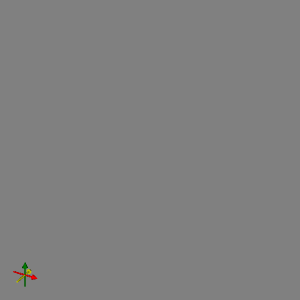
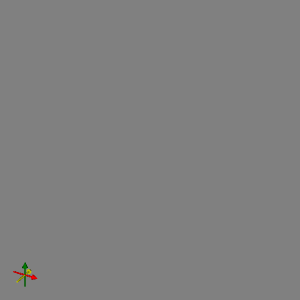

In [40]:
viewerB = view(image=ct_itk, 
               label_image=seg_itk)
viewerB.set_image_color_map("Grayscale")
viewerB.set_ui_collapsed(False)
viewerB.set_view_mode("ZPlane")
viewerB.set_z_slice(40)
viewerB.set_image_color_range([-1000,200]) # figure out good values later.


### Use custom code to overlay the CT numpy array and segmentation numpy array

In [41]:
from pyplastimatch import pyplastimatch as pypla
from pyplastimatch.utils import viz as viz_utils
from pyplastimatch.utils import data as data_utils

from matplotlib.colors import ListedColormap

cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.Greens
my_greens = cmap(np.arange(cmap.N))
my_greens[:,-1] = np.linspace(0, 1, cmap.N)
my_greens = ListedColormap(my_greens)

cmap = plt.cm.Blues
my_blues = cmap(np.arange(cmap.N))
my_blues[:,-1] = np.linspace(0, 1, cmap.N)
my_blues = ListedColormap(my_blues)

cmap = plt.cm.spring
my_spring = cmap(np.arange(cmap.N))
my_spring[:,-1] = np.linspace(0, 1, cmap.N)
my_spring = ListedColormap(my_spring)

In [42]:
# Convert nii to nrrd for viz 
verbose = True 

log_file_path_nii = "/content/pypla.txt"
# convert_args_nii = {"input": "/content/raw", 
#                     "output-img": "/content/ct.nrrd"}
# pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)

convert_args_nii = {"input": "/content/ct.nii.gz", 
                    "output-img": "/content/ct.nrrd"}
pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)

if not os.path.isdir("/content/nrrd"): 
  os.mkdir("/content/nrrd")

for n in range(0,4): 
  input_img = os.path.join("/content/seg_converted_dcmqi_resampled", str(n+1)+".nii.gz")
  output_img = os.path.join("/content/nrrd", str(n+1)+".nrrd")
  convert_args_nii = {"input": input_img, 
                    "output-img": output_img}
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)


Running 'plastimatch convert' with the specified arguments:
  --input /content/ct.nii.gz
  --output-img /content/ct.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/1.nii.gz
  --output-img /content/nrrd/1.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/2.nii.gz
  --output-img /content/nrrd/2.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/3.nii.gz
  --output-img /content/nrrd/3.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/4.nii.gz
  --output-img /content/nrrd/4.nrrd
... Done.


In [43]:
# ct_data = nib.load("/content/ct.nii.gz").get_fdata() 
# print('ct_data: ' + str(ct_data.shape))

# pred_heart = nib.load("/content/seg_converted_dcmqi_resampled/2.nii.gz").get_fdata() 
# pred_aorta = nib.load("/content/seg_converted_dcmqi_resampled/4.nii.gz").get_fdata()
# pred_trachea = nib.load("/content/seg_converted_dcmqi_resampled/3.nii.gz").get_fdata()
# pred_esophagus = nib.load("/content/seg_converted_dcmqi_resampled/1.nii.gz").get_fdata()

# ct_data = np.rollaxis(ct_data, 2, 0)
# print('ct_data: ' + str(ct_data.shape))
# pred_heart = np.rollaxis(pred_heart, 2, 0); # pred_heart = np.swapaxes(pred_heart, 1, 2)
# pred_aorta = np.rollaxis(pred_aorta, 2, 0); # pred_aorta = np.swapaxes(pred_aorta, 1, 2)
# pred_trachea = np.rollaxis(pred_trachea, 2, 0); # pred_trachea = np.swapaxes(pred_trachea, 1, 2)
# pred_esophagus = np.rollaxis(pred_esophagus, 2, 0); # pred_esophagus = np.swapaxes(pred_esophagus, 1, 2)
# ct_data = np.swapaxes(ct_data, 1, 2)

In [44]:
# _ = viz_utils.AxialSliceSegmaskViz(ct_volume = ct_data, 
#                                    segmask_dict = {"Heart" : pred_heart,
#                                                              "Aorta" : pred_aorta,
#                                                              "Trachea" : pred_trachea,
#                                                              "Esophagus" : pred_esophagus}, 
#                                    segmask_cmap_dict = {"Heart" : my_greens,
#                                                                "Aorta" : my_spring,
#                                                                "Esophagus" : my_reds,
#                                                                "Trachea" : my_blues}, 
#                                    dpi = 100)
ct_nrrd = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/ct.nrrd"), [False, True, False]))
pred_nrrd_heart = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/2.nrrd"), [False, True, False]))
pred_nrrd_aorta = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/4.nrrd"), [False, True, False]))
pred_nrrd_trachea = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/3.nrrd"), [False, True, False]))
pred_nrrd_esophagus = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/1.nrrd"), [False, True, False]))

_ = viz_utils.AxialSliceSegmaskViz(ct_volume = ct_nrrd, 
                                   segmask_dict = {"Heart" : pred_nrrd_heart,
                                                             "Aorta" : pred_nrrd_aorta,
                                                             "Trachea" : pred_nrrd_trachea,
                                                             "Esophagus" : pred_nrrd_esophagus}, 
                                   segmask_cmap_dict = {"Heart" : my_greens,
                                                               "Aorta" : my_spring,
                                                               "Esophagus" : my_reds,
                                                               "Trachea" : my_blues}, 
                                   dpi = 100)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

## Radiomics SR analysis

Go from feature to patient?? DOes this make sense? 

### Extract a single feature for one subject and all regions

Here we demonstrate how to first extract a single 3D radiomic shape features for one subject and all regions. For each region, we compare the 14 values of the manual segmentations (if it exists) to the three nnU-Net predicted models. 

In [45]:
print(series_id)

1.3.6.1.4.1.32722.99.99.232988001551799080335895423941323261228


In [46]:
# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'quantitative_measurements']) # later will change to use idc_current. 
print(table_id)

query = f"""
    SELECT 
    sourceSegmentedSeriesUID, 
    # segmentationInstanceUID, 
    SeriesDescription, 
    findingSite.CodeMeaning as region, 
    Value 
    FROM 
      {table_id}
    WHERE
      sourceSegmentedSeriesUID = @series_id AND
      Quantity[OFFSET(0)].CodeMeaning = "Sphericity"
""" 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                       ])
radiomics_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.quantitative_measurements


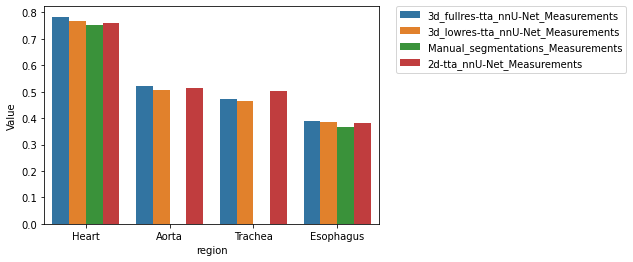

In [47]:
# For each region, plot a bar chart of the features for manual + 3 predicted models 

sns.barplot(data=radiomics_df, x="region", y="Value", hue="SeriesDescription")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


### Extract a single feature for all subjects and a single region

We also demonstrate how to extract a single feature for all subjects for a single region. We then plot the distributions of the features for the manual segmentations and the three nnU-Net predicted models. We link the OHIF viewer to further investigate any possible outliers.

In [48]:
# Query to get a single feature for all subjects/series for a single region

# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'quantitative_measurements']) # later will change to use idc_current. 
print(table_id)

region = "Heart"

query = f"""
WITH features AS (

  SELECT 
    sourceSegmentedSeriesUID, 
    SOPInstanceUID, 
    SeriesDescription, 
    Value  
  FROM 
    `bigquery-public-data.idc_current.quantitative_measurements` 
  WHERE
    Quantity[OFFSET(0)].CodeMeaning = "Sphericity" AND 
    findingSite.CodeMeaning = @region
)

SELECT 
  DISTINCT(features.sourceSegmentedSeriesUID), 
  features.SOPInstanceUID, 
  dicom_all.StudyInstanceUID, 
  dicom_all.PatientID, 
  features.SeriesDescription, 
  features.Value,
  # CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID,"?seriesInstanceUID=",features.sourceSegmentedSeriesUID) as viewer_url 
  CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID) as viewer_url 

FROM 
  features
LEFT JOIN 
  `bigquery-public-data.idc_current.dicom_all` as dicom_all 
ON 
  features.sourceSegmentedSeriesUID = dicom_all.SeriesInstanceUID 
WHERE
  dicom_all.collection_id = "nsclc_radiomics" 
ORDER BY 
  dicom_all.PatientID, 
  features.sourceSegmentedSeriesUID 
""" 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("region", "STRING", region)
                                                       ])
radiomics_df = client.query(query, job_config=job_config).to_dataframe()


bigquery-public-data.idc_current.quantitative_measurements


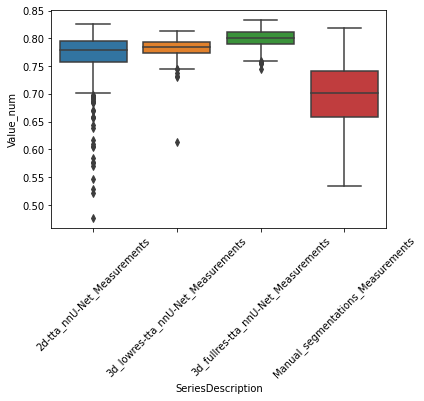

In [49]:
# Plot the distributions of the features for the manual + 3 predicted models 

radiomics_df["Value_num"] = [np.float16(f) for f in radiomics_df["Value"]]
ax = sns.boxplot(data=radiomics_df, x="SeriesDescription", y="Value_num")
ax.tick_params(axis='x', rotation=45)

In [50]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row


In [51]:
def color_list_generator(df, treatment_col):
    """ Create a list of colors per treatment given a dataframe and 
        column representing the treatments.
        
        Args:
            df - dataframe to get data from
            treatment_col - column to use to get unique treatments.
                
        Inspired by creating colors for each treatment 
        Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
        Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html
    """
    # Get the number of colors we'll need for the plot.
    # colors = brewer["Dark2"][len(df[treatment_col].unique())] # was Spectral

    print('check this value: ' + str(len(df[treatment_col].unique())))

    if (len(df[treatment_col].unique()))==1:
      # value = len(df[treatment_col].unique()[0])
      # print('value: ' + str(value))
      colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
    elif (len(df[treatment_col].unique()))==2: 
      colors = brewer["Dark2"][3][0:2]
    elif (len(df[treatment_col].unique()))>8: 
      num_colors = len(df[treatment_col].unique())
      num_colormaps = np.int32(np.ceil(num_colors/8))
      colormap_chained = brewer["Dark2"][8]*num_colormaps 
      colors = colormap_chained[0:num_colors]
    else: 
      colors = brewer["Dark2"][len(df[treatment_col].unique())]
    print(colors)

    # Create a map between treatment and color.
    colormap = {i: colors[k] for k,i in enumerate(df[treatment_col].unique())}

    # Return a list of colors for each value that we will be looking at.
    return colormap, [colormap[x] for x in df[treatment_col]]

In [52]:
# Link of OHIF url for the above 

# SeriesDescriptions_list = list(set(list(df_plot['SeriesDescription'].values)))
# num_SeriesDescriptions = len(SeriesDescriptions_list)
# print ('num_SeriesDescriptions: ' + str(num_SeriesDescriptions))

###########################################################
# --- Create a plot for each feature - just 1 for now --- #
###########################################################

#--- create df of the feature we want to plot ---# 

df_plot = radiomics_df
new_column = [np.float32(f) for f in df_plot['Value'].values]
df_plot['Value_numeric'] = new_column

SeriesDescriptions_list = list(set(list(df_plot['SeriesDescription'].values)))
num_SeriesDescriptions = len(SeriesDescriptions_list)
print ('num_SeriesDescriptions: ' + str(num_SeriesDescriptions))

#--- Plot using bokeh ---# 

output_notebook()

hover = HoverTool(tooltips=[
  (''.join(["(",'Sphericity',")"]), "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'SeriesDescription')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
SeriesDescriptions = colormap_list_keys 
print('SeriesDescriptions: ' + str(SeriesDescriptions))

# cats = df_plot.measurementGroup_number_region.unique()
cats = df_plot.SeriesDescription.unique()
print('cats: ' + str(cats))

colors = list(colormap.values())
print('colors: ' + str(colors))

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
          # x_range=cats,
            x_range=SeriesDescriptions,
          title='Sphericity')

p.circle(y='Value_numeric', x=jitter('SeriesDescription', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')


### Include the box plots ### 
# find the quartiles and IQR for each category
# groups = df_plot.groupby('regions')
# groups = df_plot.groupby('measurementGroup_number_str')
# groups = df_plot.groupby('measurementGroup_number_str')

# regions are in order we want 
category_SeriesDescription = pd.api.types.CategoricalDtype(categories=SeriesDescriptions, ordered=True)
df_plot['SeriesDescription'] = df_plot['SeriesDescription'].astype(category_SeriesDescription)

groups = df_plot.groupby('SeriesDescription')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats,
    bottom=q2.Value_numeric,
    top=q3.Value_numeric, 
    fill_color=colors,
    legend=cats
))

lower_source = ColumnDataSource(data=dict(
    x=cats,
    bottom=q1.Value_numeric, 
    top=q2.Value_numeric,
    fill_color=colors
))


# p = figure(tools="save", title="", x_range=df_plot.regions.unique())

# stems (Don't need colors of treatment)
p.segment(cats, upper.Value_numeric, cats, q3.Value_numeric, line_color="black")
p.segment(cats, lower.Value_numeric, cats, q1.Value_numeric, line_color="black")

# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

# whiskers (almost-0 height rects simpler than segments)
# p.rect(cats, lower.Value_numeric, 0.2, 0.01, line_color="black")
# p.rect(cats, upper.Value_numeric, 0.2, 0.01, line_color="black")
p.rect(cats, lower.Value_numeric, 0.2, 0.0001, line_color="black")
p.rect(cats, upper.Value_numeric, 0.2, 0.0001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])

p.add_layout(legend, 'below')    
# p.add_layout(legend, 'right')

# Setup plot titles and such.
p.title.text = 'Sphericity'
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label = "nnUNet model"
p.yaxis.axis_label="Sphericity"
# p.legend.location = (100,10)



url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

num_SeriesDescriptions: 4
check this value: 4
('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colormap: {'2d-tta_nnU-Net_Measurements': '#1b9e77', '3d_lowres-tta_nnU-Net_Measurements': '#d95f02', '3d_fullres-tta_nnU-Net_Measurements': '#7570b3', 'Manual_segmentations_Measurements': '#e7298a'}
colormap_list_keys: ['2d-tta_nnU-Net_Measurements', '3d_lowres-tta_nnU-Net_Measurements', '3d_fullres-tta_nnU-Net_Measurements', 'Manual_segmentations_Measurements']
SeriesDescriptions: ['2d-tta_nnU-Net_Measurements', '3d_lowres-tta_nnU-Net_Measurements', '3d_fullres-tta_nnU-Net_Measurements', 'Manual_segmentations_Measurements']
cats: ['2d-tta_nnU-Net_Measurements' '3d_lowres-tta_nnU-Net_Measurements'
 '3d_fullres-tta_nnU-Net_Measurements' 'Manual_segmentations_Measurements']
colors: ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


### Download a DICOM Structured Report for one subject and demonstrate how to read it using highdicom

In [53]:
radiomics_df

,sourceSegmentedSeriesUID,SOPInstanceUID,StudyInstanceUID,PatientID,SeriesDescription,Value,viewer_url,Value_num,Value_numeric,colors
0,1.3.6.1.4.1.32722.99.99.2989917765213423750108...,1.2.276.0.7230010.3.1.4.481034752.468135.16657...,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,LUNG1-001,2d-tta_nnU-Net_Measurements,0.744000000,https://viewer.imaging.datacommons.cancer.gov/...,0.744141,0.744,#1b9e77
1,1.3.6.1.4.1.32722.99.99.2989917765213423750108...,1.2.276.0.7230010.3.1.4.481034752.183145.16656...,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,LUNG1-001,3d_lowres-tta_nnU-Net_Measurements,0.788000000,https://viewer.imaging.datacommons.cancer.gov/...,0.788086,0.788,#d95f02
2,1.3.6.1.4.1.32722.99.99.2989917765213423750108...,1.2.276.0.7230010.3.1.4.481034752.147481.16643...,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,LUNG1-001,3d_fullres-tta_nnU-Net_Measurements,0.797000000,https://viewer.imaging.datacommons.cancer.gov/...,0.796875,0.797,#7570b3
3,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,1.2.276.0.7230010.3.1.4.481037312.51276.167148...,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,LUNG1-002,Manual_segmentations_Measurements,0.753000000,https://viewer.imaging.datacommons.cancer.gov/...,0.752930,0.753,#e7298a
4,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,1.2.276.0.7230010.3.1.4.481034752.112553.16656...,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,LUNG1-002,3d_lowres-tta_nnU-Net_Measurements,0.769000000,https://viewer.imaging.datacommons.cancer.gov/...,0.769043,0.769,#d95f02
...,...,...,...,...,...,...,...,...,...,...
1359,1.3.6.1.4.1.32722.99.99.3051646366712319699947...,1.2.276.0.7230010.3.1.4.481034752.187281.16656...,1.3.6.1.4.1.32722.99.99.9487282134711408248112...,LUNG1-421,3d_lowres-tta_nnU-Net_Measurements,0.800000000,https://viewer.imaging.datacommons.cancer.gov/...,0.799805,0.800,#d95f02
1360,1.3.6.1.4.1.32722.99.99.2350774061601826088292...,1.2.276.0.7230010.3.1.4.481034752.115316.16656...,1.3.6.1.4.1.32722.99.99.3228297855554221494057...,LUNG1-422,3d_lowres-tta_nnU-Net_Measurements,0.766000000,https://viewer.imaging.datacommons.cancer.gov/...,0.766113,0.766,#d95f02
1361,1.3.6.1.4.1.32722.99.99.2350774061601826088292...,1.2.276.0.7230010.3.1.4.481034752.401483.16657...,1.3.6.1.4.1.32722.99.99.3228297855554221494057...,LUNG1-422,2d-tta_nnU-Net_Measurements,0.771000000,https://viewer.imaging.datacommons.cancer.gov/...,0.770996,0.771,#1b9e77
1362,1.3.6.1.4.1.32722.99.99.2350774061601826088292...,1.2.276.0.7230010.3.1.4.481034752.71671.166429...,1.3.6.1.4.1.32722.99.99.3228297855554221494057...,LUNG1-422,3d_fullres-tta_nnU-Net_Measurements,0.788000000,https://viewer.imaging.datacommons.cancer.gov/...,0.788086,0.788,#7570b3


In [54]:
# Pick a single Radiomics SR from previous df 

# sourceSegmentedSeriesUID = radiomics_df['sourceSegmentedSeriesUID'].values[0] 
SOPInstanceUID = radiomics_df['SOPInstanceUID'].values[0]
SOPInstanceUID

'1.2.276.0.7230010.3.1.4.481034752.468135.1665722540.260168'

In [55]:
# Get the gcs_url for download for the above sourceSegmentedSeriesUID 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    SeriesDescription, 
    gcs_url
  FROM 
    {table_id}
  WHERE
    # Modality = "SR" AND 
    # collection_id = "nsclc_radiomics" AND 
    SOPInstanceUID = @SOPInstanceUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("SOPInstanceUID", "STRING", SOPInstanceUID)
                                                       ])
sr_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


In [56]:
sr_df

,SeriesDescription,gcs_url
0,2d-tta_nnU-Net_Measurements,gs://public-datasets-idc/4344dae8-58de-4f8e-8c...


In [57]:
# Download this single SR 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

# Rename file with sr.dcm 
sr_file_temp = [os.path.join(sr_directory,f) for f in os.listdir(sr_directory) if f.endswith('.dcm')][0]
sr_file = os.path.join(sr_directory, 'sr.dcm')
print(sr_file_temp)
print(sr_file)
shutil.move(sr_file_temp, sr_file)

Copying gs://public-datasets-idc/4344dae8-58de-4f8e-8cad-c914d587f5c2.dcm...
- [1/1 files][168.3 KiB/168.3 KiB] 100% Done                                    
Operation completed over 1 objects/168.3 KiB.                                    
/content/sr/4344dae8-58de-4f8e-8cad-c914d587f5c2.dcm
/content/sr/sr.dcm


'/content/sr/sr.dcm'

In [113]:
# Find all content items that may contain other content items.
test = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS,
    value_type=ValueTypeValues.CONTAINER
)
# print(test)
# print(len(test))
# print(test)

# measurements = hd.sr.utils.find_content_items(
#     dataset=sr_dataset,
#     name=codes.DCM.ImagingMeasurements,
#     recursive=True
# )
# print(measurements)


AttributeError: ignored

In [76]:
# Extract the 14 features from this SR using highdicom 

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

# Path to SR document instance stored as PS3.10 file
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

# Find all content items that may contain other content items.
containers = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS
)
print(containers)

# Query content of SR document, where content is structured according
# to TID 1500 "Measurment Report"
if sr_dataset.ContentTemplateSequence[0].TemplateIdentifier == 'TID1500':
    # Determine who made the observations reported in the document
    observers = hd.sr.utils.find_content_items(
        dataset=sr_dataset,
        name=codes.DCM.PersonObserverName
    )
    # print(observers)

    # Find all imaging measurements reported in the document
    measurements = hd.sr.utils.find_content_items(
        dataset=sr_dataset,
        name=codes.DCM.ImagingMeasurements,
        recursive=True
    )
    # print(measurements)

    # Find all findings reported in the document
    findings = hd.sr.utils.find_content_items(
        dataset=sr_dataset,
        name=codes.DCM.Finding,
        recursive=True
    )
    # print(findings)

    # Find regions of interest (ROI) described in the document
    # in form of spatial coordinates (SCOORD)
    regions = hd.sr.utils.find_content_items(
        dataset=sr_dataset,
        value_type=ValueTypeValues.SCOORD,
        recursive=True
    )
    # print(regions)



[(0040, a010) Relationship Type                   CS: 'CONTAINS'
(0040, a040) Value Type                          CS: 'CONTAINER'
(0040, a043)  Concept Name Code Sequence  1 item(s) ---- 
   (0008, 0100) Code Value                          SH: '111028'
   (0008, 0102) Coding Scheme Designator            SH: 'DCM'
   (0008, 0104) Code Meaning                        LO: 'Image Library'
   ---------
(0040, a050) Continuity Of Content               CS: 'SEPARATE'
(0040, a504)  Content Template Sequence  1 item(s) ---- 
   (0008, 0105) Mapping Resource                    CS: 'DCMR'
   (0008, 0118) Mapping Resource UID                UI: DICOM Content Mapping Resource
   (0040, db00) Template Identifier                 CS: '1600'
   ---------
(0040, a730)  Content Sequence  1 item(s) ---- 
   (0040, a010) Relationship Type                   CS: 'CONTAINS'
   (0040, a040) Value Type                          CS: 'CONTAINER'
   (0040, a043)  Concept Name Code Sequence  1 item(s) ---- 
      (00

In [85]:
containers[1]['RelationshipType']

TypeError: ignored

In [95]:
# containers[1]['ContentSequence'] # has length 4, how to get 
containers[1]['ContentSequence'][0]['ContentSequence']

# (0040, a010) Relationship Type                   CS: 'HAS CONCEPT MOD'
# (0040, a040) Value Type                          CS: 'CODE'

(0040, a010) Relationship Type                   CS: 'CONTAINS'
(0040, a040) Value Type                          CS: 'CONTAINER'
(0040, a043)  Concept Name Code Sequence  1 item(s) ---- 
   (0008, 0100) Code Value                          SH: '125007'
   (0008, 0102) Coding Scheme Designator            SH: 'DCM'
   (0008, 0104) Code Meaning                        LO: 'Measurement Group'
   ---------
(0040, a050) Continuity Of Content               CS: 'SEPARATE'
(0040, a504)  Content Template Sequence  1 item(s) ---- 
   (0008, 0105) Mapping Resource                    CS: 'DCMR'
   (0008, 0118) Mapping Resource UID                UI: DICOM Content Mapping Resource
   (0040, db00) Template Identifier                 CS: '1411'
   ---------
(0040, a730)  Content Sequence  22 item(s) ---- 
   (0040, a010) Relationship Type                   CS: 'HAS OBS CONTEXT'
   (0040, a040) Value Type                          CS: 'TEXT'
   (0040, a043)  Concept Name Code Sequence  1 item(s) ---- 
   

# Body Part Prediction results analysis

## Query and extract values from landmarks SR and plot

How to extract from SRs and put this after the querying. 


Go from patient to landmark 
pick a landmark -- list of series that have this landmark 

We first query to obtain the landmarks identified by body part regression for each subject. For a sample of 10 subjects, we then plot the landmarks present for each. (x axis subject, y axis list of landmarks, point for each landmark in a different color)

In [114]:
# First get a list of all possible landmarks from the csv file

!wget -N https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/bpr/data/bpr_landmarks_code_mapping.csv
landmarks_df = pd.read_csv("bpr_landmarks_code_mapping.csv")


--2023-03-14 20:22:52--  https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/bpr/data/bpr_landmarks_code_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797 (1.8K) [text/plain]
Saving to: ‘bpr_landmarks_code_mapping.csv’

bpr_landmarks_code_ 100%[===================>]   1.75K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2023-03-14 20:22:53 (35.7 MB/s) - ‘bpr_landmarks_code_mapping.csv’ saved [1797/1797]



In [115]:
# Download the public BPR model from Zenodo 
# Get the inference-settings.json file 
# Read the ordering of the landmarks from here - needed for some plots 

bpr_model_url = "https://zenodo.org/record/5113483/files/public_bpr_model.zip"
model_download_path = "/content/models/bpr_model.zip"
if not os.path.isdir("/content/models"):
  os.mkdir("/content/models")

!wget -O $model_download_path $bpr_model_url 

model_extract_path = "/content/models/bpr_model"
!unzip $model_download_path -d $model_extract_path

--2023-03-14 20:22:53--  https://zenodo.org/record/5113483/files/public_bpr_model.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55645041 (53M) [application/octet-stream]
Saving to: ‘/content/models/bpr_model.zip’

/content/models/bpr 100%[===================>]  53.07M   101MB/s    in 0.5s    

2023-03-14 20:22:54 (101 MB/s) - ‘/content/models/bpr_model.zip’ saved [55645041/55645041]

Archive:  /content/models/bpr_model.zip
   creating: /content/models/bpr_model/public_bpr_model/
  inflating: /content/models/bpr_model/public_bpr_model/reference.xlsx  
  inflating: /content/models/bpr_model/public_bpr_model/inference-settings.json  
  inflating: /content/models/bpr_model/public_bpr_model/model.pt  
  inflating: /content/models/bpr_model/public_bpr_model/config.json  


In [116]:
# Get data from the inference-settings.json file 

inference_settings_file = "/content/models/bpr_model/public_bpr_model/inference-settings.json" 
with open(inference_settings_file) as f: 
  inference_settings_json = json.load(f)

landmarks_inference = inference_settings_json['lookuptable_train_val']['transformed']

# # order these landmarks from inferior to superior 
# landmarks_mean = [value['mean'] for key,value in landmarks_inference.items()]
# landmarks_mean_ordered_index = np.argsort(landmarks_mean) 
# landmarks_mean_ordered_index 

# create new dictionary with ordered landmarks 
landmarks_inference_sorted = dict(sorted(landmarks_inference.items(), key=lambda item: item[1]['mean'])) 
landmarks_inference_sorted


{'pelvis_start': {'mean': 0.0, 'std': 1.983},
 'femur_end': {'mean': 13.616, 'std': 1.198},
 'L5': {'mean': 25.532, 'std': 1.854},
 'pelvis_end': {'mean': 28.824, 'std': 1.881},
 'L4': {'mean': 29.414, 'std': 2.098},
 'L3': {'mean': 33.817, 'std': 2.29},
 'kidney': {'mean': 37.597, 'std': 4.116},
 'L2': {'mean': 37.763, 'std': 2.335},
 'L1': {'mean': 41.478, 'std': 2.276},
 'lung_start': {'mean': 44.143, 'std': 4.385},
 'Th12': {'mean': 44.952, 'std': 2.287},
 'Th11': {'mean': 47.725, 'std': 2.503},
 'Th10': {'mean': 51.069, 'std': 2.717},
 'Th9': {'mean': 53.994, 'std': 2.613},
 'liver_end': {'mean': 54.479, 'std': 3.986},
 'Th8': {'mean': 56.856, 'std': 2.36},
 'Th7': {'mean': 59.851, 'std': 2.822},
 'Th6': {'mean': 63.177, 'std': 2.404},
 'Th5': {'mean': 65.964, 'std': 2.118},
 'Th4': {'mean': 68.499, 'std': 2.051},
 'Th3': {'mean': 70.973, 'std': 2.038},
 'Th2': {'mean': 73.401, 'std': 1.694},
 'lung_end': {'mean': 75.389, 'std': 1.478},
 'Th1': {'mean': 75.794, 'std': 1.811},
 'C7

In [117]:
# Query to get the landmarks for NSCLC-Radiomics 

client = bigquery.Client(project=project_name)
# table_id = ".".join(['idc-dev-etl', 'idc_v13_pub', 'dicom_all']) # later will change to use idc_current. 
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) # later will change to use idc_current. 

print(table_id)

query = f"""
--creating a temporary table that is flatenned on most columns using left joins and 
--unnesting upto three levels starting with zeroth level
--the temporary table could be very helpful to visualize.
--Once the table is flattened,
--sub tables are created, one for each attribute of interest.
--then they are joined on measurement group numbers and sop instance uid.


-- Start by creating a temporary table called 'temp'



-- Start by creating a temporary table called 'temp'
with temp as (
  -- In the SELECT statement, we're choosing which columns to include in the temporary table
  SELECT
  SOPInstanceUID, 
  bid.SeriesInstanceUID, 
  measurementGroup_number, -- Number assigned to a measurement group
  cs_l2.UID, -- Unique identifier for the content sequence at level 2
  cs_l2.TextValue, -- Text value associated with the content sequence at level 2
  collection_id, # I added 
  PatientID, 
  SeriesDescription, 
  SOPClassUID,
  cts_l0.MappingResource, -- Resource used to map the content template sequence at level 0
  cts_l0.TemplateIdentifier, -- Unique identifier for the content template sequence at level 0
  cs_l0.ValueType, -- Type of value associated with the content sequence at level 0
  cs_l1_cncs.CodeMeaning, -- Code meaning associated with the concept name coding sequence at level 1
  cs_l2.ValueType, -- Type of value associated with the content sequence at level 2
  cs_l2_cncs.CodeValue, -- Code value associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodingSchemeDesignator, -- Coding scheme designator associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodeMeaning as cm2, -- Code meaning associated with the concept name coding sequence at level 2, with an alias of 'cm2'
  cs_l2_rss.ReferencedSOPClassUID, -- Unique identifier for the referenced SOP class
  cs_l2_rss.ReferencedSOPInstanceUID, -- Unique identifier for the referenced SOP instance
  cs_l2_rss.ReferencedSegmentNumber, -- Number assigned to a referenced segment
  cs_l2_css, -- concept Code sequence associated with the content sequence at level 2
  cs_l1, -- Content sequence at level 1
  cs_l2, 
  crpes_rss.SeriesInstanceUID as crpes_ref, 
  cs_l2_cncs,
  cs_l3.ValueType vt3, -- Type of value associated with the content sequence at level 3
  cs_l3_cncs.CodeValue cv3,  -- Code value associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodingSchemeDesignator,  -- Coding scheme designator associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodeMeaning as cm3, -- Code meaning associated with the concept name coding sequence at level 3, with an alias of 'cm3'
  cs_l3_css, -- concept Code sequence associated with the content sequence at level 3

  FROM
  `bigquery-public-data.idc_current.dicom_all` bid -- Data source
  --bigquery-public-data.idc_current.dicom_metadata bid -- Data source
  -- Left join zeroth level of ContentTemplateSequence
  LEFT JOIN
  UNNEST(bid.ContentTemplateSequence) cts_l0
  -- Left join zeroth level of ContentSequence
  LEFT JOIN
  UNNEST(bid.ContentSequence) cs_l0
  -- *generate from chatgpt* 
  LEFT JOIN
  UNNEST(bid.CurrentRequestedProcedureEvidenceSequence) crpes
  -- *generate from chatgpt* 
  LEFT JOIN 
  UNNEST(crpes.ReferencedSeriesSequence) crpes_rss
  -- Unnest content sequence at level 1, with an offset assigned to measurementGroup_number
  LEFT JOIN
  unnest(cs_l0.ContentSequence) cs_l1
  WITH
  OFFSET
  AS measurementGroup_number
  -- Left join ConceptNameCodeSequence at level 1
  LEFT JOIN
  unnest(cs_l1.ConceptNameCodeSequence) cs_l1_cncs
  -- Unnest content sequence at level 2
  LEFT JOIN
  unnest(cs_l1.ContentSequence) cs_l2
  -- Left join ConceptNameCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptNameCodeSequence) cs_l2_cncs
  -- Left join ReferencedSOPSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ReferencedSOPSequence) cs_l2_rss
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptCodeSequence) cs_l2_css
  -- Unnest content sequence at level 3
  LEFT JOIN
  unnest(cs_l2.ContentSequence) cs_l3
  -- Left join ConceptNameCodeSequence at level 3
  LEFT JOIN
  unnest(cs_l3.ConceptNameCodeSequence) cs_l3_cncs
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l3.ConceptCodeSequence) cs_l3_css
  
  WHERE
  --SeriesDescription not in ("BPR landmark annotations", "BPR region annotations") and
  --PatientID in ('LUNG1-002') AND
  -- We only want to include records where the TemplateIdentifier is 1500 and MappingResource is DCMR
  TemplateIdentifier IN ('1500')
  AND MappingResource IN ('DCMR')

  -- We only want to include CONTAINER value types in the first level of content sequence
  AND cs_l0.ValueType IN ('CONTAINER')

  -- We only want to include Measurement Group Code Meanings in the second level of content sequence
  AND cs_l1_cncs.CodeMeaning IN ("Measurement Group")

  -- We want to include certain value types and code values in the third level of content sequence
  AND (
    -- Tracking Identifier-- TEXT value type with specific Code Value and Coding Scheme Designator
    (cs_l2.ValueType IN ('TEXT') AND cs_l2_cncs.CodeValue IN ('112039')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Tracking Unique Identifier--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('112040')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM'))  
    -- Referenced Segment or Source--IMAGE value type with specific Referenced SOP Class UID
    OR (cs_l2.ValueType IN ('IMAGE') AND  cs_l2_rss.ReferencedSOPClassUID IN ("1.2.840.10008.5.1.4.1.1.66.4","1.2.840.10008.5.1.4.1.1.2"))--allowing one more class for 'Source'
    -- Source series for segmentation--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('121232')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('121071')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('G-C0E3')AND cs_l2_cncs.CodingSchemeDesignator IN ('SRT'))
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('363698007')AND cs_l2_cncs.CodingSchemeDesignator IN ('SCT'))  
  )
  -- We only want to include certain SOP Class UIDs
  AND SOPClassUID IN ("1.2.840.10008.5.1.4.1.1.88.11", "1.2.840.10008.5.1.4.1.1.88.22", "1.2.840.10008.5.1.4.1.1.88.33","1.2.840.10008.5.1.4.1.1.88.34","1.2.840.10008.5.1.4.1.1.88.35") 
--and PatientID in ('LUNG1-002')
  -- We could activate the below line for testing
  -- AND SOPInstanceUID in ('1.2.276.0.7230010.3.1.4.0.11647.1553294587.292373'
),
finding as (SELECT * from temp where cm2 ='Finding'),
findingsite as (SELECT * from temp where cm2 ='Finding Site'),
ReferencedSegment as (SELECT * from temp where cm2 ='Referenced Segment'),
SourceSeriesforsegmentation as (SELECT * from temp where cm2 ='Source series for segmentation'),
TrackingIdentifier as (SELECT * from temp where cm2 ='Tracking Identifier'),
TrackingUniqueIdentifier as  (SELECT * from temp where cm2 ='Tracking Unique Identifier'),
SourceInstance as  (SELECT * from temp where cm2 ='Source')

Select
TrackingIdentifier.SOPInstanceUID, 
TrackingIdentifier.SeriesInstanceUID,
TrackingIdentifier.measurementGroup_number,
TrackingUniqueIdentifier.UID as trackingUniqueIdentifier,
TrackingIdentifier.TextValue as trackingIdentifier,
TrackingIdentifier.PatientID,
TrackingIdentifier.collection_id, 
--TrackingIdentifier.SeriesDescription,  --different from measurement groups query
SourceSeriesforsegmentation.UID as sourceSegmentedSeriesUID,
SourceInstance.ReferencedSOPInstanceUID as sourceReferencedSOPInstanceUID,--newly introduced column compared to previous qualitative query
ReferencedSegment.ReferencedSOPInstanceUID as segmentationInstanceUID,
ReferencedSegment.ReferencedSegmentNumber as segmentationSegmentNumber,
findingsite.cs_l2_cncs as Quantity, --different from measurements groups query
findingsite.cs_l2_css as Value,--different from measurements groups query
finding.cs_l2_css as finding,
findingsite.cs_l2_css as findingSite,
findingsite.cs_l3_css as findingSite_topographicalModifier, --newly introduced array compared to previous qualitative query
TrackingIdentifier.crpes_ref
# TrackingUniqueIdentifier.crpes_ref   

--TrackingIdentifier.cs_l1 as contentSequence --different from measurements groups query

from TrackingIdentifier
join TrackingUniqueIdentifier using (SOPInstanceUID, measurementGroup_number)
left join finding using (SOPInstanceUID, measurementGroup_number)
left join findingsite using (SOPInstanceUID, measurementGroup_number)
left join ReferencedSegment using (SOPInstanceUID, measurementGroup_number)
left join SourceSeriesforsegmentation using (SOPInstanceUID, measurementGroup_number)
left join SourceInstance using (SOPInstanceUID, measurementGroup_number)

-- left JOIN 
--   `bigquery-public-data.idc_current.dicom_all` as dicom_all 
-- ON 
--   SourceInstance.ReferencedSOPInstanceUID = dicom_all.SOPInstanceUID 

--the bottom line are different from measurement groups query
where findingsite.cs_l2.ValueType in ('CODE') and findingsite.cs_l2_cncs.CodeValue not in ('121071','G-C0E3') and TrackingIdentifier.collection_id = "nsclc_radiomics"

-- ORDER BY 
--   PatientID, 
--   measurementGroup_number 
"""


job_config = bigquery.QueryJobConfig()
qual_df = client.query(query, job_config=job_config).to_dataframe()


bigquery-public-data.idc_current.dicom_all


In [118]:
# Get landmarks df 

# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# just includes landmarks 
landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

In [119]:
# Get 3 seriesInstanceUIDs 

series_ids = list(set(list(landmarks_series_df['crpes_ref'].values)))
series_ids_keep = series_ids[0:3]
print(series_ids_keep)

['1.3.6.1.4.1.32722.99.99.195106556849839632270554756030848727993', '1.3.6.1.4.1.32722.99.99.60923622658554082330440372953953882674', '1.3.6.1.4.1.32722.99.99.92856589697402138233861626090796215557']


In [120]:
landmarks_series_df_keep = landmarks_series_df[landmarks_series_df["crpes_ref"].isin(series_ids_keep)]

In [121]:
# # Keep the landmarks for the 3 series we chose 

# # qual_df_keep = qual_df[qual_df['crpes_ref']==series_ids_keep] 
# qual_df_keep = qual_df[qual_df["crpes_ref"].isin(series_ids_keep)]
# qual_df_keep

In [122]:
# Get the CT series instance UID, download and convert to nifti for the 3 series 
# Get the ImagePositionPatient, ImageOrientationPatient and calculate the correct IPP for each slice. 
# Add this to the dataframe all_ct_series_df

all_ct_series_df = pd.DataFrame()


for n in range(0,3): 

  ### Query to get gcs_urls ### 

  series_id = series_ids_keep[n]
  client = bigquery.Client(project=project_name)
  query = f"""
    SELECT 
      SeriesInstanceUID,
      SOPInstanceUID, 
      gcs_url,
      ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
      ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient, 
      ARRAY_TO_STRING(PixelSpacing, "/") AS PixelSpacing
    FROM
      `bigquery-public-data.idc_current.dicom_all` 
    WHERE
      SeriesInstanceUID = @series_id;
    """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                        bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                        ])
  result = client.query(query, job_config=job_config) 
  series_df = result.to_dataframe(create_bqstorage_client=True)
  all_ct_series_df = pd.concat([all_ct_series_df,series_df])

  ### Download the gcs_urls ###

  # Create the text file to hold gsc_url 
  gs_file_path = "gcs_paths.txt"
  series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

  # Download the series 
  download_path_temp = "/content/raw_temp"
  if not os.path.isdir(download_path_temp):
    os.mkdir(download_path_temp)

  # !cat manifest.txt | gsutil -m cp -I .
  !cat gcs_paths.txt | gsutil -m cp -I $download_path_temp

  ### Convert to nii ### 

  ct_nifti_directory_temp = "/content/ct_nii_temp" 
  if not os.path.isdir(ct_nifti_directory_temp): 
    os.mkdir(ct_nifti_directory_temp)

  cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory_temp, download_path_temp)
  print(cmd)
  ret = os.system(cmd)
  print(ret)

  # Rename file 

  nii_file_orig = [os.path.join(ct_nifti_directory_temp,f) for f in os.listdir(ct_nifti_directory_temp) if f.endswith('.nii.gz')][0] 
  nii_file = os.path.join("/content/ct_qualitative", series_id + ".nii.gz")
  if not os.path.isdir("/content/ct_qualitative"):
    os.mkdir("/content/ct_qualitative")
  os.rename(nii_file_orig, nii_file)

  ### Delete from folders ### 
  !rm -rf "/content/raw_temp"
  !rm -rf "/content/ct_nii_temp" 



### Now add a column with the calculated IPP ### 

num_series = len(all_ct_series_df)
SOPInstanceUIDs = list(all_ct_series_df['SOPInstanceUID'].values) 

pos_all = [] 

for n in range(0,num_series):
  
  sop_id = SOPInstanceUIDs[n] 
  all_ct_series_df_temp = all_ct_series_df[all_ct_series_df['SOPInstanceUID']==sop_id]
  ImageOrientation = all_ct_series_df_temp['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = all_ct_series_df_temp['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)

all_ct_series_df['pos'] = pos_all 


### For each series, reorder rows from min to max and put index value ### 

all_ct_series_df_ordered = pd.DataFrame() 

for n in range(0,3): 
  series_id = series_ids_keep[n]
  series_df = all_ct_series_df[all_ct_series_df['SeriesInstanceUID'] == series_id]
  # order rows according to calculated pos 
  series_df = series_df.sort_values(by=['pos']) 
  # add an index value to the dataframe 
  all_ct_series_df_ordered = pd.concat([all_ct_series_df_ordered, series_df])


Copying gs://idc-open-cr/e7c61621-9bc2-4cc4-9755-562b1fe04df8.dcm...
Copying gs://idc-open-cr/b08a0134-50e6-4bf9-a2c7-d80065c76291.dcm...
Copying gs://idc-open-cr/0380f917-d4fb-4323-84eb-0e7e2a922f51.dcm...
Copying gs://idc-open-cr/f769a43f-a09b-41d7-a1b8-fd289fc8e9f0.dcm...
Copying gs://idc-open-cr/e4a466a1-c315-4d59-9442-98994112934c.dcm...
Copying gs://idc-open-cr/4725316f-99a9-45d1-94ce-500c48cecfbf.dcm...
Copying gs://idc-open-cr/5206b6f9-dab8-4991-bb6d-2ee6f4e5a4d8.dcm...
Copying gs://idc-open-cr/b387bfae-f366-4107-bd67-6a10bec5fc29.dcm...
Copying gs://idc-open-cr/2617066a-4552-4ed9-9d0e-ccf709838ef7.dcm...
Copying gs://idc-open-cr/dfa318aa-690a-4f13-9c80-9be8fa5f9432.dcm...
Copying gs://idc-open-cr/7b3de364-d08f-4f2b-9170-d6cb53ed35c8.dcm...
Copying gs://idc-open-cr/bd44b904-314f-49d0-86e5-6c309a834699.dcm...
Copying gs://idc-open-cr/b9b03d6e-dfa3-42dd-a642-d81eb01437e8.dcm...
Copying gs://idc-open-cr/ee1e5033-51fa-4066-a016-9422ba9d4721.dcm...
Copying gs://idc-open-cr/0bab4ec9-

In [123]:
### For each series, reorder rows from min to max and put index value ### 

all_ct_series_df_ordered = pd.DataFrame() 

for n in range(0,3): 
  series_id = series_ids_keep[n]
  series_df = all_ct_series_df[all_ct_series_df['SeriesInstanceUID'] == series_id]
  # order rows according to calculated pos 
  series_df = series_df.sort_values(by=['pos']) 
  # add an index value to the dataframe 
  slice_index = range(0,len(series_df))
  series_df['slice_index'] = slice_index
  all_ct_series_df_ordered = pd.concat([all_ct_series_df_ordered, series_df])

In [124]:
# Now for the landmarks, we also need to get the ImagePositionPatient, ImageOrientationPatient and 
# calculate the actual IPP and add to the dataframe landmarks_series_df. 

# Need to get the ImagePositionPatient and ImageOrientationPatient so I can map to actual slices. 
# ARRAY_TO_STRING(dicom_all.ImagePositionPatient,"/") AS ImagePositionPatient, 
# ARRAY_TO_STRING(dicom_all.ImageOrientationPatient, "/") AS ImageOrientationPatient

SOPInstanceUIDs = list(landmarks_series_df_keep['sourceReferencedSOPInstanceUID'].values)

client = bigquery.Client(project=project_name)
  
query_view = f"""
  SELECT 
    SOPInstanceUID, 
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient
  FROM
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SOPInstanceUID IN UNNEST (@SOPInstanceUIDs); 
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("SOPInstanceUIDs", "STRING", SOPInstanceUIDs)
                                                       ])
result = client.query(query_view, job_config=job_config) 
sop_df = result.to_dataframe(create_bqstorage_client=True)

In [125]:
print(len(landmarks_series_df_keep))
print(len(sop_df))

52
52


In [126]:
SOPInstanceUIDs = list(landmarks_series_df_keep['sourceReferencedSOPInstanceUID'].values)
num_series = len(SOPInstanceUIDs)
# SOPInstanceUIDs = sop_df['SOPInstanceUID']
# num_series = len(SOPInstanceUIDs) 

ImageOrientationPatient_all = [] 
ImagePositionPatient_all = [] 
pos_all = [] 

for n in range(0,num_series):
  
  sop_id = SOPInstanceUIDs[n] 
  sop_df_temp = sop_df[sop_df['SOPInstanceUID']==sop_id]
  ImageOrientation = sop_df_temp['ImageOrientationPatient'].values[0] 
  ImageOrientationPatient_all.append(ImageOrientation)
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]

  ImagePositionPatient = sop_df_temp['ImagePositionPatient'].values[0] 
  ImagePositionPatient_all.append(ImagePositionPatient)
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)


# Now add the three columns to landmarks_series_df
landmarks_series_df_keep['ImagePositionPatient'] = ImagePositionPatient_all 
landmarks_series_df_keep['ImageOrientationPatient'] = ImageOrientationPatient_all 
landmarks_series_df_keep['pos'] = pos_all

# Add the names of the landmarks as well 
series_landmarks_site = [f['CodeMeaning'] for f in landmarks_series_df_keep['findingSite'].values]
series_landmarks_modifier = [f['CodeMeaning'] for f in landmarks_series_df_keep['findingSite_topographicalModifier'].values] 
# join these two 
series_landmarks = [f + ' ' + g for f,g in zip(series_landmarks_site,series_landmarks_modifier)]
landmarks_series_df_keep['landmark_names'] = series_landmarks

landmarks_series_df_keep


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,SOPInstanceUID,SeriesInstanceUID,measurementGroup_number,trackingUniqueIdentifier,trackingIdentifier,PatientID,collection_id,sourceSegmentedSeriesUID,sourceReferencedSOPInstanceUID,segmentationInstanceUID,...,Quantity,Value,finding,findingSite,findingSite_topographicalModifier,crpes_ref,ImagePositionPatient,ImageOrientationPatient,pos,landmark_names
60630,1.2.826.0.1.3680043.8.498.28362333723154126310...,1.2.826.0.1.3680043.8.498.10829735019274560853...,0,1.2.826.0.1.3680043.8.498.54434468705213339208...,Annotations group landmarks 1,LUNG1-141,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2363536167524188275107...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '66794005', 'CodingSchemeDesigna...",None,"{'CodeValue': '66794005', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.1951065568498396322705...,-249.5117/-249.5117/-637.5,1/0/0/0/1/0,-637.5,L1 vertebra Center
60631,1.2.826.0.1.3680043.8.498.28362333723154126310...,1.2.826.0.1.3680043.8.498.10829735019274560853...,1,1.2.826.0.1.3680043.8.498.12722977706538928185...,Annotations group landmarks 2,LUNG1-141,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1801945935749955806978...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '39607008', 'CodingSchemeDesigna...",None,"{'CodeValue': '39607008', 'CodingSchemeDesigna...","{'CodeValue': '421610009', 'CodingSchemeDesign...",1.3.6.1.4.1.32722.99.99.1951065568498396322705...,-249.5117/-249.5117/-616.5,1/0/0/0/1/0,-616.5,Lung Bottom
60632,1.2.826.0.1.3680043.8.498.28362333723154126310...,1.2.826.0.1.3680043.8.498.10829735019274560853...,2,1.2.826.0.1.3680043.8.498.10105330928867214474...,Annotations group landmarks 3,LUNG1-141,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.3367169842229908138150...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '23215003', 'CodingSchemeDesigna...",None,"{'CodeValue': '23215003', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.1951065568498396322705...,-249.5117/-249.5117/-607.5,1/0/0/0/1/0,-607.5,T12 vertebra Center
60633,1.2.826.0.1.3680043.8.498.28362333723154126310...,1.2.826.0.1.3680043.8.498.10829735019274560853...,3,1.2.826.0.1.3680043.8.498.34129091934439187972...,Annotations group landmarks 4,LUNG1-141,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1155941438795994382205...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '12989004', 'CodingSchemeDesigna...",None,"{'CodeValue': '12989004', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.1951065568498396322705...,-249.5117/-249.5117/-586.5,1/0/0/0/1/0,-586.5,T11 vertebra Center
60634,1.2.826.0.1.3680043.8.498.28362333723154126310...,1.2.826.0.1.3680043.8.498.10829735019274560853...,4,1.2.826.0.1.3680043.8.498.49059674281625132138...,Annotations group landmarks 5,LUNG1-141,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2061404364626580981988...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '7610001', 'CodingSchemeDesignat...",None,"{'CodeValue': '7610001', 'CodingSchemeDesignat...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.1951065568498396322705...,-249.5117/-249.5117/-568.5,1/0/0/0/1/0,-568.5,T10 vertebra Center
60635,1.2.826.0.1.3680043.8.498.28362333723154126310...,1.2.826.0.1.3680043.8.498.10829735019274560853...,5,1.2.826.0.1.3680043.8.498.87917646766639664850...,Annotations group landmarks 6,LUNG1-141,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.5059283409858408211132...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '82687006', 'CodingSchemeDesigna...",None,"{'CodeValue': '82687006', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.1951065568498396322705...,-249.5117/-249.5117/-544.5,1/0/0/0/1/0,-544.5,T9 vertebra Center
60636,1.2.826.0

(118, 512)


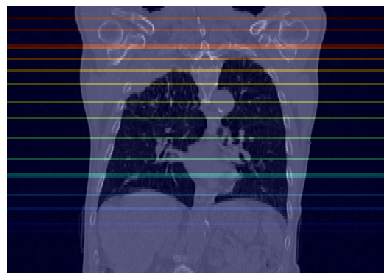

In [136]:
# For each volume 

# for n in range(0,3): 
n=0

# CT and landmarks separate dataframes for the series
series_id = series_ids_keep[n]
ct_df_plot = all_ct_series_df_ordered[all_ct_series_df_ordered['SeriesInstanceUID']==series_id]
landmarks_df_plot = landmarks_series_df_keep[landmarks_series_df_keep['crpes_ref']==series_id]

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

from matplotlib import cm
num_landmarks = len(landmarks_inference_sorted)
viridis = cm.get_cmap('viridis', num_landmarks)
# Create overlay labelmap 
landmarks_array = np.zeros((dim[2], dim[0]))
print(landmarks_array.shape)

# now match the rows of landmarks_df_plot with the ct_df_plot and get the index values!
rows_match = [np.where(f==ct_df_plot['pos'].values)[0][0] for f in landmarks_df_plot['pos'].values]
# slice_indices = ct_df_plot['slice_index'][rows_match]                   
slice_indices = ct_df_plot.iloc[rows_match]['slice_index'].values # same as rows_match.


for m in range(0,len(slice_indices)): 
  # landmarks_array[slice_indices[m],:] = m
  # later use index from where the landmark appears in the list - want the same colors across subjects 
  landmarks_array[slice_indices[m],:] = m
# flip
landmarks_array = np.flipud(landmarks_array) # because of plotting 

fig, ax = plt.subplots(1, 1)
# ax.imshow(coronal_slice_rotated, cmap='gray', vmax=1500, vmin=-1000, aspect="auto")
# ax.imshow(landmarks_array, cmap='OrRd', aspect="auto", alpha=0.5, interpolation='none')

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')
plt.imshow(landmarks_array, 'jet', interpolation='none', alpha=0.3)


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
ax.set_aspect(cor_aspect)
# plt.gca().invert_yaxis()
plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
# plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))
plt.show() 

### We have two dataframes, one with CT position info and one with landmarks position info 
# landmark_z_indices = get_landmark_indices()

# # now match the rows of landmarks_df_plot with the ct_df_plot and get the index values!
# rows_match = [np.where(f==ct_df_plot['pos'].values)[0][0] for f in landmarks_df_plot['pos'].values]
# # slice_indices = ct_df_plot['slice_index'][rows_match]                   
# slice_indices = ct_df_plot.iloc[rows_match]['slice_index'].values # same as rows_match.

# Put row across with different color by order 
# colors from ordering in landmarks_inference_sorted

# Put label legend on side 



In [128]:
ct_df_plot

,SeriesInstanceUID,SOPInstanceUID,gcs_url,ImagePositionPatient,ImageOrientationPatient,PixelSpacing,pos,slice_index
66,1.3.6.1.4.1.32722.99.99.1951065568498396322705...,1.3.6.1.4.1.32722.99.99.2194891531753301706748...,gs://idc-open-cr/ac45f59b-a624-44a4-9532-529d2...,-249.5117/-249.5117/-670.5,1/0/0/0/1/0,0.9765625/0.9765625,-670.5,0
85,1.3.6.1.4.1.32722.99.99.1951065568498396322705...,1.3.6.1.4.1.32722.99.99.1674103833559438391379...,gs://idc-open-cr/f6e43c8c-4d50-4307-8495-5a69d...,-249.5117/-249.5117/-667.5,1/0/0/0/1/0,0.9765625/0.9765625,-667.5,1
114,1.3.6.1.4.1.32722.99.99.1951065568498396322705...,1.3.6.1.4.1.32722.99.99.1307555198228961049458...,gs://idc-open-cr/231a6753-09d0-43d2-a7ec-513cd...,-249.5117/-249.5117/-664.5,1/0/0/0/1/0,0.9765625/0.9765625,-664.5,2
55,1.3.6.1.4.1.32722.99.99.1951065568498396322705...,1.3.6.1.4.1.32722.99.99.1877734313590213931322...,gs://idc-open-cr/67558aba-cfc6-4d6e-86b8-e3855...,-249.5117/-249.5117/-661.5,1/0/0/0/1/0,0.9765625/0.9765625,-661.5,3
68,1.3.6.1.4.1.32722.99.99.1951065568498396322705...,1.3.6.1.4.1.32722.99.99.1613308105365650979058...,gs://idc-open-cr/c15925c8-a6be-47a0-a414-13a9d...,-249.5117/-249.5117/-658.5,1/0/0/0/1/0,0.9765625/0.9765625,-658.5,4
...,...,...,...,...,...,...,...,...
1,1.3.6.1.4.1.32722.99.99.1951065568498396322705...,1.3.6.1.4.1.32722.99.99.1092293918528660716091...,gs://idc-open-cr/b08a0134-50e6-4bf9-a2c7-d8006...,-249.5117/-249.5117/-331.5,1/0/0/0/1/0,0.9765625/0.9765625,-331.5,113
58,1.3.6.1.4.1.32722.99.99.1951065568498396322705...,1.3.6.1.4.1.32722.99.99.3172297907608385509576...,gs://idc-open-cr/353015ed-22f2-4bdf-a8ae-76fda...,-249.5117/-249.5117/-328.5,1/0/0/0/1/0,0.9765625/0.9765625,-328.5,114
112,1.3.6.1.4.1.32722.99.99.1951065568498396322705...,1.3.6.1.4.1.32722.99.99.2273890198431008495369...,gs://idc-open-cr/b70a0cca-b902-422e-b983-621ec...,-249.5117/-249.5117/-325.5,1/0/0/0/1/0,0.9765625/0.9765625,-325.5,115
13,1.3.6.1.4.1.32722.99.99.1951065568498396322705...,1.3.6.1.4.1.32722.99.99.7923004465072456444630...,gs://idc-open-cr/ee1e5033-51fa-4066-a016-9422b...,-249.5117/-249.5117/-322.5,1/0/0/0/1/0,0.9765625/0.9765625,-322.5,116


In [129]:
rows_match = [np.where(f==ct_df_plot['pos'].values)[0][0] for f in landmarks_df_plot['pos'].values]
print(rows_match) 
print(len(rows_match))  

[11, 18, 21, 28, 34, 42, 43, 50, 59, 68, 75, 83, 89, 94, 99, 100, 107, 112]
18


In [130]:
print(ct_df_plot['pos'].values) 
temp = landmarks_df_plot['pos'].values[1]
print(temp)
print(ct_df_plot['slice_index'])

[-670.5 -667.5 -664.5 -661.5 -658.5 -655.5 -652.5 -649.5 -646.5 -643.5
 -640.5 -637.5 -634.5 -631.5 -628.5 -625.5 -622.5 -619.5 -616.5 -613.5
 -610.5 -607.5 -604.5 -601.5 -598.5 -595.5 -592.5 -589.5 -586.5 -583.5
 -580.5 -577.5 -574.5 -571.5 -568.5 -565.5 -562.5 -559.5 -556.5 -553.5
 -550.5 -547.5 -544.5 -541.5 -538.5 -535.5 -532.5 -529.5 -526.5 -523.5
 -520.5 -517.5 -514.5 -511.5 -508.5 -505.5 -502.5 -499.5 -496.5 -493.5
 -490.5 -487.5 -484.5 -481.5 -478.5 -475.5 -472.5 -469.5 -466.5 -463.5
 -460.5 -457.5 -454.5 -451.5 -448.5 -445.5 -442.5 -439.5 -436.5 -433.5
 -430.5 -427.5 -424.5 -421.5 -418.5 -415.5 -412.5 -409.5 -406.5 -403.5
 -400.5 -397.5 -394.5 -391.5 -388.5 -385.5 -382.5 -379.5 -376.5 -373.5
 -370.5 -367.5 -364.5 -361.5 -358.5 -355.5 -352.5 -349.5 -346.5 -343.5
 -340.5 -337.5 -334.5 -331.5 -328.5 -325.5 -322.5 -319.5]
-616.5
66       0
85       1
114      2
55       3
68       4
      ... 
1      113
58     114
112    115
13     116
29     117
Name: slice_index, Length: 118, d

In [131]:
# # Plot the landmarks for our sample subjects 
# # x axis subject/series, y axis list of landmarks, point for each landmark in a different color

# landmarks_regions_df = qual_df_keep[qual_df_keep['sourceSegmentedSeriesUID'].isin([None])] 
# # qual_df_keep = qual_df[qual_df["crpes_ref"].isin(series_ids_keep)]

# landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]
# regions_series_df = landmarks_regions_df[~landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]



In [132]:
# Plot the subject on the x axis and the landmarks on the y axis 

# for each series, add to plot 
# for n in range(0,3): 

n=0 

series_id = series_ids_keep[n]
# get the subset df 
series_df = landmarks_series_df[landmarks_series_df['crpes_ref']==series_id]
# get the list of landmarks 
series_landmarks_site = [f['CodeMeaning'] for f in series_df['findingSite'].values]
series_landmarks_modifier = [f['CodeMeaning'] for f in series_df['findingSite_topographicalModifier'].values] 
# join these two 
series_landmarks = [f + ' ' + g for f,g in zip(series_landmarks_site,series_landmarks_modifier)]

series_landmarks



['L1 vertebra Center',
 'Lung Bottom',
 'T12 vertebra Center',
 'T11 vertebra Center',
 'T10 vertebra Center',
 'T9 vertebra Center',
 'Liver Top',
 'T8 vertebra Center',
 'T7 vertebra Center',
 'T6 vertebra Center',
 'T5 vertebra Center',
 'T4 vertebra Center',
 'T3 vertebra Center',
 'T2 vertebra Center',
 'Lung Top',
 'T1 vertebra Center',
 'C7 vertebra Center',
 'C6 vertebra Center']

In [133]:
landmarks_total_names = [f + ' ' + g for f,g in zip(landmarks_df['CodeMeaning'].values, landmarks_df['modifier_CodeMeaning'].values)]
landmarks_total_names


['C1 vertebra Center',
 'C2 vertebra Center',
 'C3 vertebra Center',
 'C4 vertebra Center',
 'C5 vertebra Center',
 'C6 vertebra Center',
 'C7 vertebra Center',
 'T1 vertebra Center',
 'T2 vertebra Center',
 'T3 vertebra Center',
 'T4 vertebra Center',
 'T5 vertebra Center',
 'T6 vertebra Center',
 'T7 vertebra Center',
 'T8 vertebra Center',
 'T9 vertebra Center',
 'T10 vertebra Center',
 'T11 vertebra Center',
 'T12 vertebra Center',
 'L1 vertebra Center',
 'L2 vertebra Center',
 'L3 vertebra Center',
 'L4 vertebra Center',
 'L5 vertebra Center',
 'Pelvis Bottom',
 'Femur Top',
 'Pelvis Top',
 'Kidney Bottom',
 'Lung Bottom',
 'Lung Top',
 'Liver Top',
 'Teeth, gums and supporting structures Center',
 'Nose Bottom',
 'Eye Top',
 'Head Top']

In [134]:
# Now that we have the SOPInstanceUIDs of the original CT files 

In [135]:
# To the landmarks_total_names include the names of the actual landmarks from BPR and the 

## Query for specific landmark to see which patients have them 

In [ ]:
# Query for patients that have lung top and lung bottom 
# Technically this should be close to all of them! 

# For the ones that do not, plot the coronal slice of the scan, or give OHIF urls 


In [160]:
# Use qual_df instead of querying =again 
# Get a list of SeriesInstanceUIDs that don't have the lung bottom landmark 
landmark_all_series = list(set(landmarks_series_df['crpes_ref'].values))
print(len(landmark_all_series))

n=0 
single_series = landmark_all_series[n] 
landmarks_single_series_df = landmarks_series_df[landmarks_series_df['crpes_ref']==single_series] 
findingSite = [f['CodeMeaning'] for f in landmarks_single_series_df['findingSite'].values]
topModifier = [f['CodeMeaning'] for f in landmarks_single_series_df['findingSite_topographicalModifier'].values]
# combine and add as column to single df 
findingSite_and_mod = [finding]


# landmark_all_series = list(set(landmarks_series_df['sourceSegmentedSeriesUID'].values))
# print(len(landmark_all_series))

# # for n in range(0,len(landmark_all_series)):
# n=0
# single_series = landmark_all_series[n] 
# qual_df_series = qual_df[qual_df['sourceSegmentedSeriesUID']==single_series] 
# # Get list of landmarks 
# # landmark_list = qual_df_series['']
# print(qual_df_series['findingSite'].values[0]['CodeMeaning'])

# Get a list of SeriesInstanceUIDs that don't have the lung top landmarks 

414
['Center', 'Bottom', 'Center', 'Center', 'Center', 'Center', 'Top', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Top', 'Center', 'Center', 'Center']


In [153]:
qual_df_series

,SOPInstanceUID,SeriesInstanceUID,measurementGroup_number,trackingUniqueIdentifier,trackingIdentifier,PatientID,collection_id,sourceSegmentedSeriesUID,sourceReferencedSOPInstanceUID,segmentationInstanceUID,segmentationSegmentNumber,Quantity,Value,finding,findingSite,findingSite_topographicalModifier,crpes_ref
54733,1.2.276.0.7230010.3.1.4.481034752.225581.16644...,1.2.276.0.7230010.3.1.3.481034752.225581.16644...,0,1.3.6.1.4.1.43046.3.1.4.481034752.225581.16644...,Measurements group 1,LUNG1-278,nsclc_radiomics,1.3.6.1.4.1.32722.99.99.6092362265855408233044...,None,1.2.276.0.7230010.3.1.4.481034752.225069.16644...,[1],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '32849002', 'CodingSchemeDesigna...","{'CodeValue': '113343008', 'CodingSchemeDesign...","{'CodeValue': '32849002', 'CodingSchemeDesigna...",None,1.2.276.0.7230010.3.1.3.481034752.225069.16644...
54734,1.2.276.0.7230010.3.1.4.481034752.225581.16644...,1.2.276.0.7230010.3.1.3.481034752.225581.16644...,0,1.3.6.1.4.1.43046.3.1.4.481034752.225581.16644...,Measurements group 1,LUNG1-278,nsclc_radiomics,1.3.6.1.4.1.32722.99.99.6092362265855408233044...,None,1.2.276.0.7230010.3.1.4.481034752.225069.16644...,[1],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '32849002', 'CodingSchemeDesigna...","{'CodeValue': '113343008', 'CodingSchemeDesign...","{'CodeValue': '32849002', 'CodingSchemeDesigna...",None,1.2.276.0.7230010.3.1.3.481034752.225069.16644...
54735,1.2.276.0.7230010.3.1.4.481034752.225581.16644...,1.2.276.0.7230010.3.1.3.481034752.225581.16644...,0,1.3.6.1.4.1.43046.3.1.4.481034752.225581.16644...,Measurements group 1,LUNG1-278,nsclc_radiomics,1.3.6.1.4.1.32722.99.99.6092362265855408233044...,None,1.2.276.0.7230010.3.1.4.481034752.225069.16644...,[1],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '32849002', 'CodingSchemeDesigna...","{'CodeValue': '113343008', 'CodingSchemeDesign...","{'CodeValue': '32849002', 'CodingSchemeDesigna...",None,1.2.276.0.7230010.3.1.3.481034752.225069.16644...
54736,1.2.276.0.7230010.3.1.4.481034752.225581.16644...,1.2.276.0.7230010.3.1.3.481034752.225581.16644...,0,1.3.6.1.4.1.43046.3.1.4.481034752.225581.16644...,Measurements group 1,LUNG1-278,nsclc_radiomics,1.3.6.1.4.1.32722.99.99.6092362265855408233044...,None,1.2.276.0.7230010.3.1.4.481034752.225069.16644...,[1],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '32849002', 'CodingSchemeDesigna...","{'CodeValue': '113343008', 'CodingSchemeDesign...","{'CodeValue': '32849002', 'CodingSchemeDesigna...",None,1.2.276.0.7230010.3.1.3.481034752.225069.16644...
54737,1.2.276.0.7230010.3.1.4.481034752.225581.16644...,1.2.276.0.7230010.3.1.3.481034752.225581.16644...,0,1.3.6.1.4.1.43046.3.1.4.481034752.225581.16644...,Measurements group 1,LUNG1-278,nsclc_radiomics,1.3.6.1.4.1.32722.99.99.6092362265855408233044...,None,1.2.276.0.7230010.3.1.4.481034752.225069.16644...,[1],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '32849002', 'CodingSchemeDesigna...","{'CodeValue': '113343008', 'CodingSchemeDesign...","{'CodeValue': '32849002', 'CodingSchemeDesigna...",None,1.2.276.0.7230010.3.1.3.481034752.225069.16644...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370923,1.2.276.0.7230010.3.1.4.481034752.55511.166602...,1.2.276.0.7230010.3.1.3.481034752.55511.166602...,3,1.3.6.1.4.1.43046.3.1.4.481034752.55511.166602...,Measurements group 4,LUNG1-278,nsclc_radiomics,1.3.6.1.4.1.32722.99.99.6092362265855408233044...,None,1.2.276.0.7230010.3.1.4.481034752.54998.166602...,[4],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '15825003', 'CodingSchemeDesigna...","{'CodeValue': '113343008', 'CodingSchemeDesign...","{'CodeValue': '15825003', 'CodingSchemeDesigna...",None,1.3.6.1.4.1.32722.99.99.6092362265855408233044...
370924,1.2.276.0.7230010.3.1.4.481034752.55511.166602...,1.2.276.0.7230010.3.1.3.481034752.55511.166602...,3,1.3.6.1.4.1.43046.3.1.4.481034752.55511.16660

## Query and extract values from regions SR and plot

We first query to obtain the regions identified by body part regression (for each slice) for each subject. For a sample of 10 subjects, we demonstrate the number of slices assigned to each region. (x axis subject, y axis range of number of slices, bars for each region that overlap if multiple regions are assigned to a slice)

In [ ]:
# First query to obtain the regions identified by body part regression (for each slice) across all subject/series



In [ ]:
# For a sample of subjects, plot the range of slices assigned to each region 
# x axis subject, y axis range of number of slices
# bars for each region that overlap if multiple 


Sort by the number of slices/landmarks to see coverage 

## Query for specific region to see which patients have it 

In [ ]:
# Pick a region like the chest 
# Check which patients have this region 

# For those that don't, plot coronal slices to see, or give OHIF urls. 

## Download the DICOM Structured Reports for a single subject for both landmarks and regions, and demonstrate using highdicom how to read them 

In [ ]:
# Pick a single Radiomics SR from previous df 

# sourceSegmentedSeriesUID = radiomics_df['sourceSegmentedSeriesUID'].values[0] 
SOPInstanceUID = radiomics_df['SOPInstanceUID'].values[0]
SOPInstanceUID

'1.2.276.0.7230010.3.1.4.481034752.468135.1665722540.260168'

In [ ]:
# Get the gcs_url for download for the above sourceSegmentedSeriesUID 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    SeriesDescription, 
    gcs_url
  FROM 
    {table_id}
  WHERE
    # Modality = "SR" AND 
    # collection_id = "nsclc_radiomics" AND 
    SOPInstanceUID = @SOPInstanceUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("SOPInstanceUID", "STRING", SOPInstanceUID)
                                                       ])
sr_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


In [ ]:
sr_df

,SeriesDescription,gcs_url
0,2d-tta_nnU-Net_Measurements,gs://public-datasets-idc/4344dae8-58de-4f8e-8c...


In [ ]:
# Download this single SR 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

# Rename file with sr.dcm 
sr_file_temp = [os.path.join(sr_directory,f) for f in os.listdir(sr_directory) if f.endswith('.dcm')][0]
sr_file = os.path.join(sr_directory, 'sr.dcm')
print(sr_file_temp)
print(sr_file)
shutil.move(sr_file_temp, sr_file)

Copying gs://public-datasets-idc/4344dae8-58de-4f8e-8cad-c914d587f5c2.dcm...
- [1/1 files][168.3 KiB/168.3 KiB] 100% Done                                    
Operation completed over 1 objects/168.3 KiB.                                    
/content/sr/4344dae8-58de-4f8e-8cad-c914d587f5c2.dcm
/content/sr/sr.dcm


'/content/sr/sr.dcm'

Get the gcs_url for the DICOM Structured Reports

In [7]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['idc-dev-etl', 'idc_v13_pub', 'dicom_all']) # later will change to use idc_current. 
print(table_id)

query = f"""
  SELECT 
    PatientID, 
    StudyInstanceUID,
    SeriesInstanceUID, 
    SOPInstanceUID, 
    SeriesDescription,
    gcs_url
  FROM 
    {table_id}
  WHERE
    Modality = "SR" AND 
    collection_id = "nsclc_radiomics"
  ORDER BY 
    PatientID, 
    StudyInstanceUID, 
    SeriesInstanceUID;
"""

job_config = bigquery.QueryJobConfig()
sr_df = client.query(query, job_config=job_config).to_dataframe()

idc-dev-etl.idc_v13_pub.dicom_all


KeyboardInterrupt: ignored

Use same PatientID as before

In [ ]:
sr_df_patient = sr_df[sr_df['PatientID']==PatientID] 
sr_df_patient

Download the DICOM Structured Reports 

In [ ]:
# Download all the DICOM Structured Reports files for body part regression 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df_patient["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

Use dicomsort to sort the DICOM files 

In [ ]:
# Sort files 
sr_directory_sorted = "/content/sr_sorted"
if not os.path.join(sr_directory_sorted):
  os.mkdir(sr_directory_sorted)

!python src/dicomsort/dicomsort.py -u $sr_directory $sr_directory_sorted/%PatientID/%Modality/%SeriesDescription.dcm



# DELETE later - Older code 

## Obtain the ground truth DICOM Segmentation objects from the NSCLC-Radiomics collection

In [ ]:
# Get all of the ground truth segmentations for NSCLC-Radiomics 

if (gce_vm): 
  client = bigquery.Client()
else: 
  client = bigquery.Client(project=project_name)

query = """
      

with seg_sops AS (
  SELECT 
    PatientID, 
    SOPInstanceUID
  FROM 
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    Modality = "SEG" and 
    collection_id = "nsclc_radiomics"
  ORDER BY 
    PatientID 
), 

referenced_series AS(
  SELECT 
    dicom_all.PatientID, 
    dicom_all.StudyInstanceUID, 
    dicom_all.SeriesInstanceUID, 
    dicom_all.SOPInstanceUID, 
    dicom_all.ReferencedSeriesSequence[OFFSET(0)].SeriesInstanceUID as ReferencedSeriesInstanceUID, 
    dicom_all.gcs_url 
  FROM 
    `bigquery-public-data.idc_current.dicom_all` as dicom_all 
  JOIN 
    seg_sops
  ON 
    dicom_all.SOPInstanceUID = seg_sops.SOPInstanceUID 
  WHERE
    collection_id = "nsclc_radiomics"
  ORDER BY 
    PatientID 
) 

SELECT 
  referenced_series.PatientID, 
  referenced_series.StudyInstanceUID, 
  referenced_series.SeriesInstanceUID, 
  referenced_series.SOPInstanceUID, 
  referenced_series.ReferencedSeriesInstanceUID, 
  referenced_series.gcs_url
FROM 
  referenced_series; 
# JOIN 
#   # UNNEST(['1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046', '1.3.6.1.4.1.32722.99.99.232988001551799080335895423941323261228']) as select_series
#   UNNEST(@series_ids) as select_series 
# ON 
#   referenced_series.ReferencedSeriesInstanceUID = select_series

  """

# job_config = bigquery.QueryJobConfig(    
#     query_parameters=[
#         bigquery.ArrayQueryParameter("series_ids", "STRING", series_ids)])
job_config = bigquery.QueryJobConfig()
seg_df = client.query(query, job_config=job_config).to_dataframe()

## Converting DICOM Segmentation objects

In [ ]:
seg_df

,PatientID,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,ReferencedSeriesInstanceUID,gcs_url
0,LUNG1-001,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,1.2.276.0.7230010.3.1.3.2323910823.20524.15972...,1.2.276.0.7230010.3.1.4.2323910823.20524.15972...,1.3.6.1.4.1.32722.99.99.2989917765213423750108...,gs://idc-open-cr/553521b9-f9e8-4103-b04d-5f032...
1,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.2.276.0.7230010.3.1.3.2323910823.11504.15972...,1.2.276.0.7230010.3.1.4.2323910823.11504.15972...,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,gs://idc-open-cr/eff917af-8a2a-42fe-9e12-22bce...
2,LUNG1-003,1.3.6.1.4.1.32722.99.99.2477262867958601216867...,1.2.276.0.7230010.3.1.3.2323910823.23864.15972...,1.2.276.0.7230010.3.1.4.2323910823.23864.15972...,1.3.6.1.4.1.32722.99.99.2389222799296192439904...,gs://idc-open-cr/8b8ec28d-1e6f-41a3-85f6-d1dac...
3,LUNG1-004,1.3.6.1.4.1.32722.99.99.2026036697036260886779...,1.2.276.0.7230010.3.1.3.2323910823.4780.159726...,1.2.276.0.7230010.3.1.4.2323910823.4780.159726...,1.3.6.1.4.1.32722.99.99.2809816144625926346520...,gs://idc-open-cr/a3619297-0f76-4fc2-8fc5-b5c59...
4,LUNG1-005,1.3.6.1.4.1.32722.99.99.7196186628043392557101...,1.2.276.0.7230010.3.1.3.2323910823.11644.15972...,1.2.276.0.7230010.3.1.4.2323910823.11644.15972...,1.3.6.1.4.1.32722.99.99.3490584753983772067630...,gs://idc-open-cr/7481751e-53e9-437e-b70b-572a7...
...,...,...,...,...,...,...
416,LUNG1-418,1.3.6.1.4.1.32722.99.99.2550183916074767392057...,1.2.276.0.7230010.3.1.3.2323910823.9396.159725...,1.2.276.0.7230010.3.1.4.2323910823.9396.159725...,1.3.6.1.4.1.32722.99.99.1452469930699451440457...,gs://idc-open-cr/1847ef93-fae7-4282-9057-5be93...
417,LUNG1-419,1.3.6.1.4.1.32722.99.99.3021605337118254296273...,1.2.276.0.7230010.3.1.3.2323910823.25160.15972...,1.2.276.0.7230010.3.1.4.2323910823.25160.15972...,1.3.6.1.4.1.32722.99.99.1485019640321281490267...,gs://idc-open-cr/8300eea1-30fd-4710-a437-9331f...
418,LUNG1-420,1.3.6.1.4.1.32722.99.99.2607665217932065751026...,1.2.276.0.7230010.3.1.3.2323910823.1672.159725...,1.2.276.0.7230010.3.1.4.2323910823.1672.159725...,1.3.6.1.4.1.32722.99.99.3116735173196404572362...,gs://idc-open-cr/66aa1bb6-32b6-47ca-aad3-3c29f...
419,LUNG1-421,1.3.6.1.4.1.32722.99.99.9487282134711408248112...,1.2.276.0.7230010.3.1.3.2323910823.18724.15972...,1.2.276.0.7230010.3.1.4.2323910823.18724.15972...,1.3.6.1.4.1.32722.99.99.3051646366712319699947...,gs://idc-open-cr/86dac2ac-a0f2-4738-a65b-4a711...


There are multiple ways a DICOM Segmentation object can be read. First, let's download a few of the DICOM Segmentation objects so that we can convert them. 

Download a DICOM Segmentation object for a single series

In [ ]:
download_path = "/content/raw"
if not os.path.isdir(download_path):
  os.mkdir(download_path)

series_id = seg_df['ReferencedSeriesInstanceUID'].values[0] 
print('series_id: ' + str(series_id))
series_df = seg_df[seg_df['ReferencedSeriesInstanceUID']==series_id]

# Create the text file to hold gsc_url 
gcsurl_temp = "cp " + series_df["gcs_url"].str.replace("gs://","s3://") + " " + download_path 
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Get the path for s5cmd
if os.path.exists('/content/s5cmd'):
  s5cmd_path = '/content/s5cmd'
else:
  s5cmd_path = '/s5cmd'

# Download using s5cmd 
start_time = time.time()
download_cmd = [s5cmd_path,"--endpoint-url", "https://storage.googleapis.com", "run", gs_file_path]
proc = subprocess.Popen(download_cmd)
proc.wait()
elapsed = time.time() - start_time 
print ("Done download in %g seconds."%elapsed)

series_id: 1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
Done download in 1.38519 seconds.


Convert to nii.gz files using dcmqi segimage2itkimage function 

In [ ]:
input_filename = [os.path.join("/content/raw",f) for f in os.listdir("/content/raw") if f.endswith('.dcm')][0]
output_directory = "/content/seg2nii_dcmqi"
if not os.path.isdir(output_directory): 
  os.mkdir(output_directory)

bash_command = list()
bash_command += ["segimage2itkimage"]
bash_command += ["--outputType", "nii"]
bash_command += ["--outputDirectory", "%s"%output_directory]
bash_command += ["--inputDICOM", "%s"%input_filename]

bash_return = subprocess.run(bash_command, check = True, text = True)

Convert to nifti files using highdicom 

In [ ]:
# https://highdicom.readthedocs.io/en/latest/usage.html#parsing-segmentation-seg-images

output_directory = "/content/seg2nii_highdicom"
if not os.path.isdir(output_directory): 
  os.mkdir(output_directory) 

from pathlib import Path
import highdicom as hd
from pydicom.filereader import dcmread
import nibabel as nib 

# Path to multi-frame SEG image instance stored as PS3.10 file
seg_file = Path(input_filename)

# Read SEG Image data set from PS3.10 files on disk
seg_dataset = dcmread(str(seg_file))

# Iterate over segments and print the information about the frames
# that encode the segment across different image positions
segments_number = [] 
segment_label = [] 
segment_description = [] 
for frames, frame_descriptions, description in hd.seg.utils.iter_segments(seg_dataset):
    segments_number.append(description.SegmentNumber)
    segment_label.append(description.SegmentLabel)
    segment_description.append(description.SegmentDescription)
    # save as nii 
    img = nib.Nifti1Image(frames,np.eye(4))
    nib.save(img,str(description.SegmentNumber)+'.nii.gz')


In [ ]:
print(segments_number)
print(segment_label)
print(segment_description)

[1, 2, 3, 4]
['Neoplasm, Primary', 'Lung', 'Lung', 'Spinal cord']
['GTV-1', 'Lung-Left', 'Lung-Right', 'Spinal-Cord']


## Analysis of DICOM SR for the features 

Pick a single feature and plot the values for all 4 regions for 3d_fullres-tta model. 

Pick a single feature and region, and plot all values across the models. 